Main Leaderboard

Forecaster  | Peer score against Pros | % Beat Pros on same Qs (Bootstrap) | % Beat Pros on same Qs (Resample)

Resample: Linear interpolation of two forecasters to determine "ground truth" for resampling. "Ground truth" = weighted combination of percent forecasts on each question that yields the most accurate score. Weights are 0 to 1.

Correlation: Deal with by assigning weights to questions. Weights for independent questions are 1. "Approximately correct rather than precisely wrong." Would be good to have a rule of thumb. These weights can be used for leaderboard above.

Likely want % beat Pros to be beyond 95% for significance - but obviously a sliding scale.

Can use this method for Metaculus Track Record! Have separate line for each platform - so can see significance against each platform. Then combine all competeing platforms and treat as the same forecaster going head-to-head against Metaculus!

Heroku:

Bots: https://data.heroku.com/dataclips/bmlboxtaewpwemfvqwktqxernfeq

Pros: https://data.heroku.com/dataclips/rozqhydlvqrzsllgmioruallozjx

In [1]:
# @title Import libraries
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime
from scipy import stats

In [2]:
# @title Create df_bot_resolved_questions, df_pro_resolved_questions, df_pro_bot_resolved_questions, df_bot_question_weights

"""
Input question data for both bots and pros.

Only look at questions that have resolved Yes or No.

df_pro_resolved_questions: Has pro_question_id, title, resolution, scheduled_close_time
df_bot_resolved_questions: Has bot_question_id, title, resolution, scheduled_close_time

All pro questions are asked to bots, but not all bot questions are asked to pros (correction:
not true in 2024 Q4, there were some that got launched to pros first? and were bad so they
didn't get asked of bots?)

To compare pros to bots, we need to match the pro_question_id with the bot_question_id.
This is done by matching the title and scheduled_close_time.

We remove early closers from the analysis. I do this by comparing actual close time to scheduled
close time in a later cell!

df_pro_bot_resolved_questions: Has pro_question_id, bot_question_id, title, resolution, scheduled_close_time, question_weight
"""

df_bot_scores = pd.read_csv(f'https://data.heroku.com/dataclips/nudnpycciffydoeihwbtttlkwpcj.csv')
df_bot_scores.to_csv('scores/bots_score_data_q4.csv', index=False)
#df_bot_scores = pd.read_csv('scores/bots_score_data_q3.csv')
df_bot_questions = df_bot_scores.rename(columns={'question_id': 'bot_question_id', 'question_title': 'title'})
df_bot_questions = df_bot_questions[df_bot_questions['resolution'].isin(['yes', 'no'])]

df_pro_scores = pd.read_csv(f'https://data.heroku.com/dataclips/dgoglqeavaxrhhnfcikkoobuollk.csv')
df_pro_scores.to_csv('scores/pros_score_data_q4.csv', index=False)
#df_pro_scores = pd.read_csv('scores/pros_score_data_q3.csv')
df_pro_questions = df_pro_scores.rename(columns={'question_id': 'pro_question_id', 'question_title': 'title'})
df_pro_questions = df_pro_questions[df_pro_questions['resolution'].isin(['yes', 'no'])]

df_pro_resolved_questions = df_pro_questions[['pro_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]
df_bot_resolved_questions = df_bot_questions[['bot_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]

df_pro_bot_resolved_questions = pd.merge(
    df_bot_resolved_questions,
    df_pro_resolved_questions[['pro_question_id', 'title', 'scheduled_close_time', 'question_weight']],
    on=['title', 'scheduled_close_time'],
    how='left'
)

df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_x'].combine_first(df_pro_bot_resolved_questions['question_weight_y'])
df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

# Remove duplicates
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions.drop_duplicates()

# Cast both question ids to int64
df_pro_bot_resolved_questions['pro_question_id'] = df_pro_bot_resolved_questions['pro_question_id'].astype('Int64')
df_pro_bot_resolved_questions['bot_question_id'] = df_pro_bot_resolved_questions['bot_question_id'].astype('Int64')

# Remove df_bot_resolved_questions and df_pro_resolved_questions to make sure you only ever use df_pro_bot_resolved_questions
del df_bot_resolved_questions
del df_pro_resolved_questions

In [4]:
# TK: See whether Cassie's intervals on peer score is in the same range as Q3 - if a lot of people "burst their bounds" that would be kind of weird (tom)
# If no one updated their bots from Q3 to Q4, then 95% of the bots should land within their bounds
# ... But people did update their bots

In [5]:
# Are any of the weights NOT 1 -- for Q3 we need to assign weights "manually" but for Q4 they are there
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

126


In [6]:
b = df_pro_bot_resolved_questions.shape

# How many are NA for pro_question_id?
a = df_pro_bot_resolved_questions['pro_question_id'].isna().sum()

print(f'Total number bot questions: {b[0]}')
print(f'Bot questions that don\'t have pro counterpart: {a}')
print(f'Overlap between bot and pro questions: {b[0]-a}')

Total number bot questions: 402
Bot questions that don't have pro counterpart: 280
Overlap between bot and pro questions: 122


In [7]:
# Weighted vs unweighted breakdown for those overlapping questions?
df_pro_bot_overlap = df_pro_bot_resolved_questions[~df_pro_bot_resolved_questions['pro_question_id'].isna()]
df_pro_bot_overlap['weighted'] = df_pro_bot_overlap['question_weight'] != 1
print(f'Unweighted count: {df_pro_bot_overlap["weighted"].sum()}')
print(f'Weighted count: {df_pro_bot_overlap.shape[0] - df_pro_bot_overlap["weighted"].sum()}')

Unweighted count: 48
Weighted count: 74


/tmp/ipykernel_2209775/752954740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro_bot_overlap['weighted'] = df_pro_bot_overlap['question_weight'] != 1


In [8]:
# @title Relationships between Bot Questions, create df_bot_question_related_weights (FOR Q3 ONLY)
if 25871 in df_pro_bot_resolved_questions['bot_question_id'].values:
  """
  Relationships between questions are entered as tuples. These relationships
  will be used to perform logical consistency checks.

  Weights are assigned to questions based on relationships. This is a way to
  deal with correlations between questions.
  """

  # Scope sensitity list of tuples where the first entry should equal the sum of the others
  bot_scope_questions = [
        (26019, 26017, 26018), # Starship launches
        (26098, 26096, 26097), # SENSEX
        (26159, 26158, 26157), # Geomagnetic storm July 28
        (26194, 26195, 26196), # measles cases
        (26006, 26005, 26004), # Trump lead over Biden
        (26642, 26643, 26644), # spanish wikipedia
        (26700, 26701, 26702), # market cap cryptocurrencies
        (27261, 27262, 27263), # Geomagnetic storm Sept 11
        ]

  # Sum of each tuple should logically equal 1
  bot_sum_to_1_questions = [
      (25952, 25953, 25954), # French PM party July 30
      (25957, 25958, 25959), # Tour de France winner
      (26570, 26571, 26572, 26573), # Warhammer
      (26574, 26575, 26576, 26577), # H5 cases in US
      (26671, 26670, 26669), # DOES NOT SUM TO EXACTLY 1 PM France Aug 31
      (27748, 27747, 27746, 27749), # Speed Chess
      (27488, 27489, 27490, 27491, 27492, 27493), # August CPI
      (27932, 27933, 27934, 27935), # Chinese youth unemployment
      (27484, 27485, 27486, 27487), # Fed rate cut Sept meeting
      (28045, 28044, 28043, 28042), # Afd vote share
      (28038, 28039, 28040, 28041), # Major Atlantic hurricanes
      (26776, 26777, 26778, 26779), # Seattle-Tacoma-Bellevu Air Quality
      ]

  # parent, child, if_yes, if_no
  bot_conditional_pair = [
      (26917, 26918, 26919, 26920) # israel lebanon conflict
  ]

  # CDFs - Logically the probability of each successive question must not decrease
  bot_increasing_questions = [
      (26981, 26982, 26983, 26984, 26985, 26986), # aircraft ADIZ
      (26977, 26978, 26979, 26980), # hurricane energy
      (27548, 27547, 27546, 27545), # mpox CDC risk level
      (28306, 28305, 28304, 28303, 28302), # Gas prices in US Sept 30
  ]

  bot_repeated_questions = [
      (26646, 26021), # mens 100m dash record
      (26555, 27021), # USA gold silver
      (26210, 26917), # israel invade lebanon
      (26781, 26304), # ruto
      (26100, 27136), # rfk drop out
      (25956, 27158), # democrat brokered convention
      (26102, 27022), # astronauts NOT EXACT REPEAT
      (26022, 27085), # arrest warrants NOT EXACT REPEAT
      (26235, 27281), # Buffett Indicator
      (26390, 27789), # Bubble Magnificent 7
      (26024, 27161), # QB Bo Nix starting for Broncos
      (26302, 27282), # riots
      (25955, 27157), # armed forces death US, China, Japan
      (26958, 27640), # Youtube banned in Russia
      (25936, 27141), # Crimean bridge attack
  ]

  bot_similar_questions = [
      (26915, 26916), # harris favorability
      (26913, 26914), # trump favorability
      (26193, 27733), # debate on Sept 10
      (27886, 27968), # Taylor Swift awards
      (27723, 27637), # Best Rock VMAs
      (27583, 27582, 27584, 27602, 27603, 27604), # mpox Zambia, US, Angola, Russia, Japan, Mexico
      (26306, 26838), # Richest people 250th > $10.2, 500th > 6.2
      (27887, 27969), # Emmys Outstanding Limited or Anthology Series
      (28206, 28207, 28208, 28209, 28210), # LMSYS leaderboard
      (28154, 28336), # Nigeria Edo gubernatorial election
      (26407, 27897), # Second Russian mobilization wave
      (27539, 26215), # Nuclear weapons used
      (27606, 27607, 27608, 27609, 27610), # Ukranian forces capture
      (26387, 27788), # Will Tesla increase deliveries in Q3 2024
      (26821, 26959), # VP debate
      (26212, 26213, 26214), # number of dairy cow herds with H5N1
      (26639, 26640, 26641), # Presidential debate 0, 1, or 2+
  ]

  ####### CREATE QUESTION WEIGHTS #########

  # Combine both lists of tuples
  all_questions = bot_scope_questions + bot_sum_to_1_questions + bot_increasing_questions + bot_similar_questions + bot_conditional_pair

  # Create an empty list to store the data
  data = []

  # Process each tuple
  for tuple_questions in all_questions:
      # Calculate the weight for each question in the tuple
      weight = np.log2(1 + len(tuple_questions))/(1 + len(tuple_questions))

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': weight})

  # Process each tuple
  for tuple_questions in bot_repeated_questions:
      # 1st iteration has weight 1, 2nd has weight 1/2, 3rd weight 1/3....
      count = 1

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': 1/count})
          count += 1

  # Create the DataFrame
  df = pd.DataFrame(data)

  # Sort the DataFrame by bot_question_id for better readability
  df_bot_question_related_weights = df.sort_values('bot_question_id').reset_index(drop=True)

# if df_bot_question_related_weights is defined, replace the question weights in df_pro_bot_resolved_questions
if 'df_bot_question_related_weights' in locals():
    df_pro_bot_resolved_questions = pd.merge(
        df_pro_bot_resolved_questions,
        df_bot_question_related_weights,
        on='bot_question_id',
        how='left'
    )

    df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_y'].combine_first(df_pro_bot_resolved_questions['question_weight_x'])
    df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

In [9]:
# Are there any non-1 weights (there should be)
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

126


In [10]:
# Unique pro questions, bot questions
pro_questions = df_pro_bot_resolved_questions['pro_question_id'].unique()
bot_questions = df_pro_bot_resolved_questions['bot_question_id'].unique()
print(pro_questions, bot_questions)

<IntegerArray>
[28887, 28888, 28889,  <NA>, 28942, 28943, 28944, 28972, 28973, 29053,
 ...
 30622, 30644, 30645, 30729, 30730, 30753, 30757, 30758, 30759, 30760]
Length: 123, dtype: Int64 <IntegerArray>
[28922, 28923, 28924, 28932, 28933, 28934, 28935, 28936, 28937, 28938,
 ...
 30740, 30741, 30787, 30791, 30792, 30793, 30794, 30795, 30796, 30797]
Length: 402, dtype: Int64


In [11]:
df_pro_bot_resolved_questions.dtypes

bot_question_id           Int64
title                    object
resolution               object
scheduled_close_time     object
actual_close_time        object
pro_question_id           Int64
question_weight         float64
dtype: object

In [12]:
# Remove early closers IF right now is before scheduled close time
df_pro_bot_resolved_questions['scheduled_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['scheduled_close_time']).dt.tz_localize(None)
df_pro_bot_resolved_questions['actual_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['actual_close_time']).dt.tz_localize(None)

In [13]:
remove_early_closers = False # SET TO FALSE WHEN ALL Q'S ARE RESOLVED
if remove_early_closers:
  df_pro_bot_resolved_questions = df_pro_bot_resolved_questions[(df_pro_bot_resolved_questions['actual_close_time'] <= df_pro_bot_resolved_questions['scheduled_close_time'])]

print('Number of unique questions in df_pro_bot_resolved_questions:', len(df_pro_bot_resolved_questions['bot_question_id']))

Number of unique questions in df_pro_bot_resolved_questions: 402


In [14]:
# Step 1: Read in the scores dataclips from heroku, take last (spot) score for each question_id, forecaster pair; make it into what Tom's code expects

## BOTS

# BASELINE
df_bot_baseline = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_baseline = df_bot_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

# PEER
df_bot_peer = df_bot_scores[df_bot_scores['score_type'] == 'spot_peer']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_peer = df_bot_peer.groupby(['question_id', 'forecaster']).last().reset_index()

## PROS

# BASELINE
df_pro_baseline = df_pro_scores[df_pro_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_pro_baseline = df_pro_baseline.groupby(['question_id', 'forecaster']).last().reset_index()
df_pro_baseline_long = df_pro_baseline.copy()

# ADD THE BOT MEDIAN SPOT SCORE & REMOVE UNNECESSARY COLUMNS
df_bot_baseline = df_bot_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Calculate medians and preserve metadata
medians = (df_bot_baseline
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_baseline = pd.concat([df_bot_baseline, medians])
df_bot_baseline_long = df_bot_baseline.copy()

# DO THE SAME FOR DF_BOT_PEER
df_bot_peer = df_bot_peer[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Get all columns except score and forecaster (TK: Does it make sense to take median of peer scores?)
medians = (df_bot_peer
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_peer = pd.concat([df_bot_peer, medians])

df_bot_baseline_long.head()

,question_id,question_title,question_weight,forecaster,score,resolution
0,28922,Will a senolytic therapy be approved for comme...,1.0,000_bot,84.799691,no
1,28922,Will a senolytic therapy be approved for comme...,1.0,Bot_Pepa,95.009509,no
2,28922,Will a senolytic therapy be approved for comme...,1.0,GreeneiBot2,81.885056,no
3,28922,Will a senolytic therapy be approved for comme...,1.0,HSeldon,84.799691,no
4,28922,Will a senolytic therapy be approved for comme...,1.0,InstitutPelFutur,52.606881,no


In [15]:
# Step 2: FILTER TO ONLY THOSE QUESTION ID's THAT ARE IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_bot_peer = df_bot_peer[df_bot_peer['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline = df_bot_baseline[df_bot_baseline['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline_long = df_bot_baseline_long[df_bot_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_baseline = df_pro_baseline[df_pro_baseline['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_pro_baseline_long = df_pro_baseline_long[df_pro_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_bot_scores = df_bot_scores[df_bot_scores['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_scores = df_pro_scores[df_pro_scores['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]

In [16]:
all_bots = df_bot_peer['forecaster'].unique()
all_bots

array(['000_bot', 'Bot_Pepa', 'GreeneiBot2', 'HSeldon',
       'InstitutPelFutur', 'Jay_Bailey_Bot', 'MWG', 'RonanMcGovern',
       'RyansAGI', 'SeidrBot', 'SynapseSeer', 'VeritasAI', 'acm_bot',
       'annabot', 'archipelago', 'bestworldbot', 'biak_bot', 'estr.ai',
       'histerio', 'jkraybill_bot', 'karamazov', 'lostandfound',
       'mf-bot-1', 'mf-bot-3', 'mf-bot-4', 'pgodzinai', 'silicoqr',
       'twsummerbot', 'Cassie', 'tombot61', 'tombot37', 'Panshul42',
       'HunchexBot', 'SaraBase', 'Unwrapped80T', 'mmBot', 'manticAI',
       'gnosis-ai', 'lookahead', 'mf-bot-5', 'predictomatic',
       'Grizeu_Bot', 'hlb-bot', 'ProfessorSP', 'bot_median'], dtype=object)

In [17]:
# Unique score_type in df_bot_scores
df_bot_scores['score_type'].unique()

array(['baseline', 'peer', 'spot_baseline', 'relative_legacy',
       'spot_peer'], dtype=object)

In [18]:
def calculate_weighted_stats(df):
    results = []

    # For each forecaster
    for forecaster in df['forecaster'].unique():
        forecaster_data = df[df['forecaster'] == forecaster]

        # Get scores and weights
        scores = forecaster_data['score']
        weights = forecaster_data['question_weight']

        # Calculate weighted mean
        weighted_mean = np.average(scores, weights=weights)
        weighted_sum = np.sum(scores * weights)

        # Calculate weighted standard error
        # Using weighted variance formula
        weighted_var = np.average((scores - weighted_mean)**2, weights=weights)
        n = len(scores)
        weighted_se = np.sqrt(weighted_var / n)

        # Calculate t-statistic for 95% confidence interval
        t_value = stats.t.ppf(0.975, n-1)
        ci_lower = weighted_mean - (t_value * weighted_se)

        results.append({
            'forecaster': forecaster,
            'weighted_mean': weighted_mean,
            'weighted_sum': weighted_sum,
            'n_questions': n,
            'ci_lower': ci_lower,
            'weighted_se': weighted_se
        })

    # Convert to dataframe and sort by lower bound
    results_df = pd.DataFrame(results)
    return results_df.sort_values('weighted_sum', ascending=False)

# Calculate and show results
ranked_forecasters = calculate_weighted_stats(df_bot_peer)

ranked_forecasters.head(10)

,forecaster,weighted_mean,weighted_sum,n_questions,ci_lower,weighted_se
25,pgodzinai,12.826379,4282.723798,401,9.026268,1.933002
44,bot_median,10.621972,3546.672836,401,9.404700,0.619189
6,MWG,9.178352,2737.287471,354,5.122354,2.062329
18,histerio,7.050509,2354.162689,401,3.868728,1.618476
2,GreeneiBot2,6.954808,2322.207987,401,3.751725,1.629311
36,manticAI,7.071527,2214.924896,377,3.362347,1.886382
24,mf-bot-4,6.582129,2197.770497,401,1.470498,2.600132
13,annabot,7.146344,1954.825671,325,4.623433,1.282415
28,Cassie,4.499759,1403.473288,379,0.911123,1.825108
39,mf-bot-5,3.572909,1009.426831,339,-1.393551,2.524881


In [19]:
# @title Create df_bot_baseline, df_bot_peer, df_bot_forecasts, bots

"""
df_bot_baseline: Spot Baseline scores for all bots & bot_median

df_bot_peer: Spot Peer scores for all bots & bot_median. Can be used to recreate
the tournament leaderboard on the site.

df_bot_forecasts: Spot forecasts for all bots & bot_median, ie only counts the
final forecast

bots: a list of all bots
"""

# Pivot df_bot_baseline
df_bot_baseline = df_bot_baseline.rename(columns={'question_id': 'bot_question_id'})
#df_bot_baseline['score'] = pd.to_numeric(df_bot_baseline['score'], errors='coerce')
df_pivoted = df_bot_baseline.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
# Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_baseline_wide = df_pivoted
df_bot_baseline_wide['bot_question_id'] = pd.to_numeric(df_bot_baseline_wide['bot_question_id'], errors='coerce')

# Create df_bot_peer
df_bot_peer = df_bot_peer.rename(columns={'question_id': 'bot_question_id'})
df_bot_peer['score'] = pd.to_numeric(df_bot_peer['score'], errors='coerce')


def make_wide(df_bot_peer):
  df_pivoted = df_bot_peer.pivot(index='bot_question_id', columns='forecaster', values='score')
  df_pivoted = df_pivoted.reset_index()
  df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

  # Step 4: Move 'question_id' to be the first column
  cols = df_pivoted.columns.tolist()
  cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
  df_pivoted = df_pivoted[cols]

  all_columns = df_pivoted.columns.tolist()
  ## Remove 'question_id' and 'bot_median' from the list if they exist
  all_columns = [col for col in all_columns if col not in ['bot_question_id']]
  new_column_order = ['bot_question_id'] + all_columns
  df_pivoted = df_pivoted[new_column_order]
  df_bot_peer_wide = df_pivoted
  df_bot_peer_wide['bot_question_id'] = pd.to_numeric(df_bot_peer_wide['bot_question_id'], errors='coerce')

  # Join with df_pro_bot_resolved_questions to get question weights
  df_bot_peer_wide = pd.merge(
      df_bot_peer_wide,
      df_pro_bot_resolved_questions[['bot_question_id', 'question_weight']],
      on='bot_question_id',
      how='left'
  )

  return df_bot_peer_wide

df_bot_peer_wide = make_wide(df_bot_peer)


In [20]:
################ CONVERT BASELINE SCORE TO FORECAST ###################

def convert_baseline_to_forecasts(df):
    # Assumes columns: 'bot_question_id' 'resolution'
    result_df = df.copy()

    def score_to_forecast(score, resolution):
        if resolution == 'yes':
            return 2 ** (score/100 - 1)
        else:
            return 1 - 2 ** (score/100 - 1)

    score_columns = ['score']
    #score_columns = [col for col in score_columns if col not in ['bot_question_id', 'resolution', 'pro_question_id']]

    for col in score_columns:
        result_df['forecast'] = result_df.apply(lambda row: score_to_forecast(row[col], row['resolution']), axis=1)

    return result_df

df_bot_forecasts = convert_baseline_to_forecasts(df_bot_baseline)
df_bot_forecasts = df_bot_forecasts.drop('resolution', axis=1)

df_bot_forecasts.head()

,bot_question_id,question_title,question_weight,forecaster,score,forecast
0,28922,Will a senolytic therapy be approved for comme...,1.0,000_bot,84.799691,0.100
1,28922,Will a senolytic therapy be approved for comme...,1.0,Bot_Pepa,95.009509,0.034
2,28922,Will a senolytic therapy be approved for comme...,1.0,GreeneiBot2,81.885056,0.118
3,28922,Will a senolytic therapy be approved for comme...,1.0,HSeldon,84.799691,0.100
4,28922,Will a senolytic therapy be approved for comme...,1.0,InstitutPelFutur,52.606881,0.280


In [21]:
# @title Bot Baseline Leaderboard

# Calculate the total score for each bot
total_scores = df_bot_baseline_wide.iloc[:, 1:].fillna(0).sum()

# Create a new dataframe with the total scores
df_total_scores = pd.DataFrame({'Bot': total_scores.index, 'Baseline_Score': total_scores.values})

# Sort the dataframe by Total_Score in descending order
df_total_scores_sorted = df_total_scores.sort_values('Baseline_Score', ascending=False)

# Add a Rank column
df_total_scores_sorted['Rank'] = range(1, len(df_total_scores_sorted) + 1)

# Set Rank as the index
df_total_scores_ranked = df_total_scores_sorted.set_index('Rank')

# Display the result
df_total_scores_ranked

,Bot,Baseline_Score
Rank,,
1,pgodzinai,11449.061880
2,bot_median,10376.347256
3,histerio,8846.913447
4,GreeneiBot2,8600.016276
5,MWG,8586.674336
6,mf-bot-4,8397.207105
7,manticAI,8232.126891
8,annabot,6713.492148
9,twsummerbot,6281.953028


In [22]:
# @title Bot Peer Leaderboard

"""
NOTE: This can be different from the leaderboad on the site IF early closers
are excluded (check remove_early_closers bool).
"""

df_filled = df_bot_peer_wide.fillna(0)
#df_filled = df_filled.drop(['bot_question_id', 'question_weight'], axis=1)

# Calculate the total score for each player
total_scores = df_filled.sum()

# Create a new DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'bot': total_scores.index,
    'Peer Score': total_scores.values
})

# Remove bot_question_id from the leaderboard
leaderboard = leaderboard[leaderboard['bot'] != 'bot_question_id']

# Sort the leaderboard by Total Score in descending order
leaderboard = leaderboard.sort_values('Peer Score', ascending=False)

# Reset the index and add a 'Rank' column
leaderboard = leaderboard.reset_index(drop=True)
leaderboard.index += 1
leaderboard.index.name = 'Rank'

# Display the leaderboard
leaderboard

,bot,Peer Score
Rank,,
1,pgodzinai,4982.051525
2,bot_median,4196.093229
3,histerio,3126.484915
4,MWG,3087.447561
5,GreeneiBot2,2931.197884
6,manticAI,2806.809000
7,mf-bot-4,2774.521073
8,annabot,2384.161677
9,Cassie,1493.459548


In [23]:
# ADD PRO_MEDIAN ROWS

df_pro_scores = df_pro_baseline

# Create pro_median: for each question, calculate the median score
median_scores = df_pro_scores.groupby('question_id')['score'].median().reset_index()
median_scores = median_scores.rename(columns={'score': 'median_score'})  # rename to avoid confusion

# Create template rows with metadata
template_rows = df_pro_scores.groupby('question_id').first().reset_index()

# Create new rows with median scores
median_rows = template_rows.merge(median_scores, on='question_id', how='left')
median_rows['forecaster'] = 'pro_median'
median_rows['score'] = median_rows['median_score']  # assign the median to score column
median_rows = median_rows.drop('median_score', axis=1)  # clean up temporary column

# Concatenate original DataFrame with new median rows
df_combined = pd.concat([df_pro_scores, median_rows], ignore_index=True)

df_pro_scores = df_combined

df_combined.tail()

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
1204,30753,pro_median,Will Blue Origin launch its New Glenn rocket b...,2024-12-12 14:53:09.414413+00,101465,48.542683,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30991
1205,30757,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.494041+00,101465,84.799691,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30995
1206,30758,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.642963+00,101465,-32.192809,spot_baseline,yes,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30996
1207,30759,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.66238+00,101465,31.034012,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30997
1208,30760,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.682954+00,101465,92.599942,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30998


In [24]:
df_bot_scores = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

In [25]:
# @title Create df_pro_baseline, df_pro_forecasts

"""
WARNING: This may not exclude early closers.

df_pro_baseline: Spot Baseline scoes for all pros & pro_median

df_pro_forecasts: Spot forecasts for all pros & pro_median
"""

# Pivot df_pro_scores (baseline)
#df_pro_scores = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})
#df_pivoted = df_pro_scores.pivot(index='pro_question_id', columns='forecaster', values='score')
#df_pivoted = df_pivoted.reset_index()
#df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

#cols = df_pivoted.columns.tolist()
#cols = ['pro_question_id'] + [col for col in cols if col != 'pro_question_id']
#df_pivoted = df_pivoted[cols]

#all_columns = df_pivoted.columns.tolist()
#all_columns = [col for col in all_columns if col not in ['pro_question_id', 'pro_median']]
#new_column_order = ['pro_question_id', 'pro_median'] + all_columns
#df_pivoted = df_pivoted[new_column_order]
#df_pro_baseline = df_pivoted
#df_pro_baseline['pro_question_id'] = pd.to_numeric(df_pro_baseline['pro_question_id'], errors='coerce')


#print(f"Shape of df_pro_baseline: {df_pro_baseline.shape}")
#print(df_pro_baseline.columns)


#df_temp = pd.merge(
    #df_pro_baseline,
    #df_pro_scores[['pro_question_id', 'resolution']],
    #on='pro_question_id',
    #how='left'
#)

df_pro_forecasts = convert_baseline_to_forecasts(df_pro_scores)
df_pro_forecasts = df_pro_forecasts.drop('resolution', axis=1)

df_pro_forecasts.head()

#print(f"Shape of df_pro_forecasts: {df_pro_forecasts.shape}")
#print(df_pro_forecasts.columns)


,question_id,forecaster,question_title,created_at,user_id,score,score_type,scheduled_close_time,actual_close_time,question_weight,post_id,forecast
0,28887,Jgalt,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,101465,99.421765,spot_baseline,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948,0.004
1,28887,MaciekK,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,117580,99.566541,spot_baseline,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948,0.003
2,28887,OpenSystem,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,120160,98.841203,spot_baseline,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948,0.008
3,28887,Sergio,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,115725,99.711172,spot_baseline,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948,0.002
4,28887,Zaldath,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,139161,98.550043,spot_baseline,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948,0.010


In [26]:
# @title Create df_pro_bot_forecasts, df_bot_vs_pro_peer, df_bot_vs_pro_leaderboard, df_bot_vs_pro_weighted_leaderboard

"""
df_pro_bot_forecasts: Spot forecasts for all bots & pro_median, question resolutions, and question weights

df_bot_vs_pro_peer: Calculates Peer scores as if there is a tournament with only
a single bot and the pro_median. This is the main comparison metric for
assessing how a bot compares to the human aggregate. Positive scores mean that
the bot did better than the pro_median. Negative scores mean that the bot did
worse than the pro_median.

df_bot_vs_pro_leaderboard: A leaderboard based on df_bot_vs_pro_peer.

df_bot_vs_pro_weighted_leaderboard: A leaderboard based on df_bot_vs_pro_peer
with question weighting.
"""

# Now pivot df_pro_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_pro_forecasts = df_pro_forecasts.rename(columns={'question_id': 'pro_question_id'})
df_pro_forecasts = df_pro_forecasts.pivot(index='pro_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_pro_forecasts = df_pro_forecasts.reset_index()

# Now pivot df_bot_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_bot_forecasts = df_bot_forecasts.rename(columns={'question_id': 'bot_question_id'})
df_bot_forecasts = df_bot_forecasts.pivot(index='bot_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_bot_forecasts = df_bot_forecasts.reset_index()

# One row per question, with pro_question_id and bot_question_id and resolution
df_pro_bot_resolved_questions_first = df_pro_bot_resolved_questions.groupby(['pro_question_id', 'bot_question_id']).first().reset_index()[['pro_question_id', 'bot_question_id', 'resolution', 'question_weight']]

df2 = pd.merge(
    df_pro_bot_resolved_questions_first,
    df_pro_forecasts[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df2,
    df_bot_forecasts,
    on='bot_question_id',
    how='left'
)

df_pro_bot_forecasts.tail()

,pro_question_id,bot_question_id,resolution,question_weight,pro_median,000_bot,Bot_Pepa,Cassie,GreeneiBot2,Grizeu_Bot,...,mf-bot-3,mf-bot-4,mf-bot-5,mmBot,pgodzinai,predictomatic,silicoqr,tombot37,tombot61,twsummerbot
117,30753,30787,no,1.0000,0.30,0.600,0.79,0.166667,0.186,0.15,...,0.20,0.15,0.15,0.15,0.14,NaN,NaN,NaN,NaN,0.263
118,30757,30791,no,0.4644,0.10,0.850,0.71,0.890000,0.112,0.72,...,0.06,0.20,0.65,0.55,0.12,NaN,NaN,NaN,NaN,0.278
119,30758,30792,yes,0.4644,0.40,0.600,0.53,0.529167,0.288,0.45,...,0.04,0.75,0.65,0.70,0.34,NaN,NaN,NaN,NaN,0.233
120,30759,30793,no,0.4644,0.38,0.575,0.67,0.379167,0.404,0.45,...,0.40,0.20,0.65,0.65,0.41,NaN,NaN,NaN,NaN,0.283
121,30760,30794,no,0.4644,0.05,0.050,0.31,0.154167,0.180,0.15,...,0.04,0.10,0.25,0.25,0.13,NaN,NaN,NaN,NaN,0.450


In [27]:
#print(f"Shape of df_pro_bot_forecasts: {df_pro_bot_forecasts.shape}")
#print(df_pro_bot_forecasts.columns)

# Create a new DataFrame to store peer scores
df_bot_vs_pro_peer = df_pro_bot_forecasts.copy()
df_bot_vs_pro_peer = df_bot_vs_pro_peer[['pro_median', 'resolution', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in all_bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_pro_bot_forecasts['resolution'] == 'yes',
        np.log(df_pro_bot_forecasts[bot] / df_pro_bot_forecasts['pro_median']),
        np.log((1 - df_pro_bot_forecasts[bot]) / (1 - df_pro_bot_forecasts['pro_median']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_pro_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team
peer_score = np.where(
    df_pro_bot_forecasts['resolution'] == 'yes',
    np.log(df_pro_bot_forecasts['bot_median'] / df_pro_bot_forecasts['pro_median']),
    np.log((1 - df_pro_bot_forecasts['bot_median']) / (1 - df_pro_bot_forecasts['pro_median']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_pro_peer["bot_team_median"] = 100 * peer_score

In [28]:
total_scores = df_bot_vs_pro_peer.sum(axis=0)
# remove resolution, question_weight, bot_question_id from total scores
total_scores = total_scores.drop(['resolution', 'question_weight', 'bot_question_id'])

# First pivot to long format - each row will be a question-forecaster pair
df_long = df_bot_vs_pro_peer.melt(
    id_vars=['bot_question_id', 'question_weight', 'resolution'],
    var_name='forecaster',
    value_name='score'
)

# Drop any rows where score is NaN
df_long = df_long.dropna(subset=['score'])

# Cast question_weight as numeric
df_long['question_weight'] = pd.to_numeric(df_long['question_weight'], errors='coerce')

# Group first, then do the multiplication and sum
weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))

# Calculate number of questions answered by each bot
num_questions = df_long.groupby('forecaster')['bot_question_id'].nunique()
#num_weighted_questions = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Peer_vs_Pro': total_scores,
    'Count': num_questions
})

weighted_results = pd.DataFrame({
    'W_Peer_vs_Pro': weighted_scores,
    'Count': num_questions
})

df_bot_vs_pro_leaderboard = results.sort_values(by='Peer_vs_Pro', ascending=False)
df_bot_vs_pro_weighted_leaderboard = weighted_results.sort_values(by='W_Peer_vs_Pro', ascending=False)

/tmp/ipykernel_2209775/2414215139.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))


In [29]:
df_pro_scores

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
0,28887,Jgalt,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,101465,99.421765,spot_baseline,no,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948
1,28887,MaciekK,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,117580,99.566541,spot_baseline,no,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948
2,28887,OpenSystem,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,120160,98.841203,spot_baseline,no,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948
3,28887,Sergio,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,115725,99.711172,spot_baseline,no,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948
4,28887,Zaldath,Will a senolytic therapy be approved for comme...,2024-10-18 22:22:15.921432+00,139161,98.550043,spot_baseline,no,2024-10-22 14:30:00+00,2024-10-22 14:30:00+00,1.0,28948
...,...,...,...,...,...,...,...,...,...,...,...,...
1204,30753,pro_median,Will Blue Origin launch its New Glenn rocket b...,2024-12-12 14:53:09.414413+00,101465,48.542683,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30991
1205,30757,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.494041+00,101465,84.799691,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30995
1206,30758,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.642963+00,101465,-32.192809,spot_baseline,yes,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30996
1207,30759,pro_median,Will US airline passenger volume be for the we...,2024-12-12 14:53:09.66238+00,101465,31.034012,spot_baseline,no,2024-12-14 15:30:00+00,2024-12-14 15:30:00+00,1.0,30997


In [30]:
# Rename question_id to pro_question_id in df_pro_baseline and filter to only baseline score_type
df_pro_baseline = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})[df_pro_scores['score_type'] == 'spot_baseline']
df_pro_baseline = df_pro_baseline[['pro_question_id', 'forecaster', 'score']]

# Now make it wide! forecaster = columns; score = values; index = pro_question_id
df_pro_baseline_wide = df_pro_baseline.pivot(index='pro_question_id', columns='forecaster', values='score').reset_index()

In [31]:
# @title Create df_pro_bot_baseline_leaderboard, df_pro_bot_baseline_weighted_leaderboard

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_resolved_questions,
    df_bot_baseline_wide,
    on='bot_question_id',
    how='left'
)

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_baseline_weights,
    df_pro_baseline_wide[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

# Remove rows where pro_question_id is NaN (only want overlapping questions here)
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.dropna(subset=['pro_question_id'])

# Create a list of columns to keep
forecaster_cols = ['pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()
question_weighted_counts = df_filtered.notna().mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values,
    'Weighted Count': question_weighted_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count', 'Weighted Count']]

#leaderboard
weighted_leaderboard

,Rank,Forecaster,Weighted_Baseline,Count,Weighted Count
0,1,pro_median,4127.018973,122,96.2956
1,2,pgodzinai,2904.186174,122,96.2956
2,3,mf-bot-4,2833.306246,122,96.2956
3,4,MWG,2508.130919,108,85.2956
4,5,bot_median,2474.563120,122,96.2956
5,6,twsummerbot,2121.405579,120,95.2956
6,7,GreeneiBot2,2038.805197,122,96.2956
7,8,histerio,1991.217274,122,96.2956
8,9,estr.ai,1986.551824,100,76.4380
9,10,manticAI,1873.867821,116,90.2956


In [32]:
# @title function t_critical_value

def t_critical_value(df):
    # Dictionary containing t-values for 95% confidence interval (2-tailed)
    t_table = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571,
        6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262, 10: 2.228,
        11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131,
        16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086,
        21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
        26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042,
        40: 2.021, 50: 2.009, 60: 2.000, 70: 1.994, 80: 1.990,
        90: 1.987, 100: 1.984, 1000: 1.962, float('inf'): 1.960
    }

    # Check if df is in the table
    if df in t_table:
        return t_table[df]

    # If df is not in the table, find the closest lower df
    lower_df = max(key for key in t_table.keys() if key <= df)

    # If df is between two values, perform linear interpolation
    if lower_df < df:
        upper_df = min(key for key in t_table.keys() if key > df)
        lower_t = t_table[lower_df]
        upper_t = t_table[upper_df]

        # Linear interpolation
        t_value = lower_t + (upper_t - lower_t) * (df - lower_df) / (upper_df - lower_df)
        return round(t_value, 3)

    return t_table[lower_df]


# Example usage
#print(f"Critical t-value for df=3.5: {t_critical_value(3.5)}")
#print(f"Critical t-value for df=35: {t_critical_value(35)}")
#print(f"Critical t-value for df=200: {t_critical_value(200)}")

In [33]:
# TK: Sanity check. Look at MWG and RyansAGI individual questions - some weird resolutions where the pros were caught off guard
# So maybe the bots are really (almost all) this much worse than pros? Looking at the table below.
# Those "unexpected" resolutions what kept the bots in the game last quarter, maybe.

In [34]:
# How many questions in df_bot_vs_pro_peer
df_bot_vs_pro_peer.shape

(122, 50)

In [35]:
def calculate_t_test(df_input, bot_list, weight_col='question_weight'):
    """
    Calculate weighted statistics including t-test and p-values for multiple bots.
    
    Parameters:
    -----------
    df_input : pandas.DataFrame
        Dataframe with PEER SCORES, like df_bot_vs_pro_peer - comparing each bot
        to the pro median.
    bot_list : list
        List of column names corresponding to bot scores
    weight_col : str, optional
        Name of the column containing weights (default: 'question_weight')
        
    Returns:
    --------
    pandas.DataFrame
        Leaderboard dataframe with calculated statistics for each bot
    """
    # Initialize results dataframe
    df_W_leaderboard = pd.DataFrame(index=bot_list)
    
    for bot in bot_list:
        # Create working copy with just needed columns
        df3 = df_input[[bot, weight_col]].copy()
        df3 = df3.dropna()
        df3 = df3.reset_index(drop=True)
        
        # Calculate weighted statistics
        weighted_score = (df3[bot] * df3[weight_col]).sum()
        weighted_count = df3[weight_col].sum()
        
        if weighted_count > 2:  # Only calculate if we have enough data
            weighted_average = weighted_score / weighted_count
            weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3[weight_col]).sum() / (weighted_count - 1))
            std_error = weighted_std_dev / np.sqrt(weighted_count)
            t_statistic = (weighted_average - 0) / std_error
            
            # Get t-critical value and confidence bounds
            t_crit = stats.t.ppf(0.975, df=weighted_count-1)  # 95% confidence level
            upper_bound = weighted_average + t_crit * std_error
            lower_bound = weighted_average - t_crit * std_error
            
            # Calculate CDF and p-value
            cdf = stats.t.cdf(t_statistic, df=weighted_count-1)
            p_value = 2 * min(cdf, 1 - cdf)  # Two-tailed p-value
            
        else:  # Not enough data
            weighted_average = weighted_score / weighted_count if weighted_count > 0 else np.nan
            weighted_std_dev = np.nan
            std_error = np.nan
            t_statistic = np.nan
            t_crit = np.nan
            upper_bound = np.nan
            lower_bound = np.nan
            cdf = np.nan
            p_value = np.nan
        
        # Store results
        df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
        df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
        df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
        df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
        df_W_leaderboard.loc[bot, 'std_err'] = std_error
        df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
        df_W_leaderboard.loc[bot, 't_crit'] = t_crit
        df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
        df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
        df_W_leaderboard.loc[bot, 'cdf'] = cdf
        df_W_leaderboard.loc[bot, 'p_value'] = p_value
    
    # Format and round the results
    df_W_leaderboard['W_score'] = df_W_leaderboard['W_score'].round(1)

    # Store numerical p-values temporarily for sorting
    df_W_leaderboard['_p_value_sort'] = df_W_leaderboard['p_value']
    
    # Format p-values as percentages
    df_W_leaderboard['p_value'] = df_W_leaderboard['p_value'].apply(
        lambda x: f"{x*100:.4f}%" if pd.notnull(x) else "NA"
    )
    
    # Round other columns
    df_W_leaderboard[['W_ave', 'W_count', 'lower_bound', 'upper_bound']] = \
        df_W_leaderboard[['W_ave', 'W_count', 'lower_bound', 'upper_bound']].round(1)
    
    # Sort by the numerical p-values
    df_W_leaderboard = df_W_leaderboard.sort_values(
        by='W_score',
        ascending=False,
        na_position='last'
    )
    
    # Drop the temporary sorting column
    df_W_leaderboard = df_W_leaderboard.drop('_p_value_sort', axis=1)
     
    return df_W_leaderboard

In [36]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_pro_peer with question
weighting and the calculations for doing a weighted T test
"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0) # TK: IS THIS IN FACT OK

# Cast weights as numeric
df_bot_vs_pro_peer['question_weight'] = pd.to_numeric(df_bot_vs_pro_peer['question_weight'], errors='coerce')

# Calculate weighted statistics for each bot
df_W_leaderboard = calculate_t_test(df_bot_vs_pro_peer, all_bots)

df_W_leaderboard

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
hlb-bot,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
HunchexBot,-48.3,5.0,-9.7,24.489524,10.952048,-0.881718,2.776445,20.8,-40.1,2.138634e-01,42.7727%
tombot37,-108.1,15.0,-7.2,20.513992,5.296690,-1.360521,2.144787,4.2,-18.6,9.758404e-02,19.5168%
Panshul42,-181.2,26.5,-6.8,38.448653,7.464942,-0.915221,2.057380,8.5,-22.2,1.843201e-01,36.8640%
lookahead,-240.4,7.0,-34.3,51.902029,19.617123,-1.750877,2.446912,13.7,-82.3,6.526611e-02,13.0532%
predictomatic,-247.8,7.0,-35.4,105.195490,39.760158,-0.890183,2.446912,61.9,-132.7,2.038207e-01,40.7641%
ProfessorSP,-382.2,21.4,-17.9,83.722126,18.116071,-0.987715,2.083617,19.9,-55.6,1.674437e-01,33.4887%
lostandfound,-503.3,12.5,-40.2,78.008028,22.039068,-1.822861,2.188742,8.1,-88.4,4.717154e-02,9.4343%
silicoqr,-530.4,25.1,-21.2,50.391489,10.066908,-2.102564,2.063642,-0.4,-41.9,2.307530e-02,4.6151%
jkraybill_bot,-590.2,51.1,-11.5,42.264111,5.909672,-1.952732,2.008414,0.3,-23.4,2.822204e-02,5.6444%


In [37]:
# @title Weighted Bot Peer, T test (to compare bots against each other, use ALL QUESTIONS)

df_W_bot_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# OMIT bot_median column for this bit
df_bot_peer_wide_b = df_bot_peer_wide.drop('bot_median', axis=1)
df_bot_peer = df_bot_peer[df_bot_peer['forecaster'] != 'bot_median']

bots_for_peer = np.array(list(set(df_bot_peer['forecaster'])))

df_W_leaderboard = calculate_t_test(df_bot_peer_wide_b, bots_for_peer)

df_W_leaderboard_print = df_W_leaderboard.sort_values(by='lower_bound', ascending=False)
df_W_leaderboard_print['Rank'] = range(1, len(df_W_leaderboard_print) + 1)

# Make index into a column - Bot
df_W_leaderboard_print = df_W_leaderboard_print.reset_index()
df_W_leaderboard_print = df_W_leaderboard_print.rename(columns={'index': 'Bot'})
df_W_leaderboard_print = df_W_leaderboard_print[['Rank', 'Bot', 'W_ave', 'W_count', 'lower_bound', 'upper_bound']]

df_W_leaderboard_print

,Rank,Bot,W_ave,W_count,lower_bound,upper_bound
0,1,pgodzinai,12.8,333.9,8.7,17.0
1,2,MWG,9.2,298.2,4.7,13.6
2,3,annabot,7.1,273.5,4.4,9.9
3,4,histerio,7.1,333.9,3.6,10.5
4,5,GreeneiBot2,7.0,333.9,3.4,10.5
5,6,manticAI,7.1,313.2,3.0,11.2
6,7,mf-bot-4,6.6,333.9,1.0,12.2
7,8,Cassie,4.5,311.9,0.5,8.5
8,9,mf-bot-5,3.6,282.5,-1.9,9.0
9,10,tombot37,5.8,84.0,-2.2,13.7


In [38]:
# Write to csv
df_W_leaderboard_print.to_csv('weighted_bot_peer_leaderboard_t_test.csv', index=False)

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2209775/3429998090.py:29: SyntaxWarning: invalid escape sequence '\m'
  textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
/tmp/ipykernel_2209775/3429998090.py:29: SyntaxWarning: invalid escape sequence '\s'
  textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'


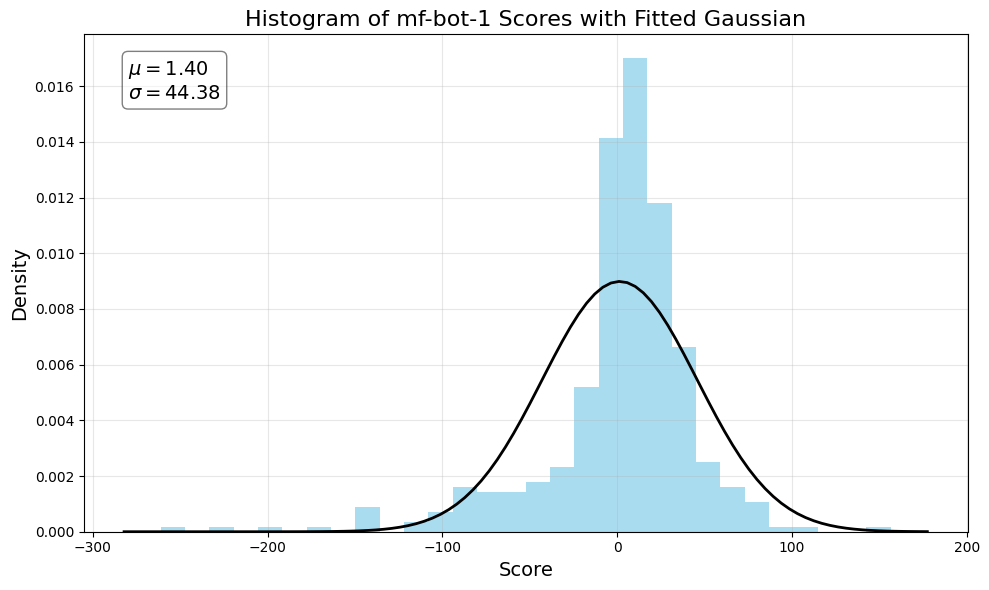

In [39]:
# @title Histogram of bot

# Extract the 'mf-bot-1' column and remove NaN values
#scores = df_bot_vs_pro_peer['FJ_Researcher01+bot'].dropna()

name = 'mf-bot-1'

scores = df_bot_peer_wide[name].dropna()

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=30, density=True, alpha=0.7, color='skyblue')

# Fit a normal distribution to the data
mu, std = norm.fit(scores)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title(f"Histogram of {name} Scores with Fitted Gaussian", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add text box with distribution parameters
textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
df_bot_peer_wide.shape

# Print all_bots in alphabetical order
df_bot_peer_wide.head()

,bot_question_id,000_bot,Bot_Pepa,Cassie,GreeneiBot2,Grizeu_Bot,HSeldon,HunchexBot,InstitutPelFutur,Jay_Bailey_Bot,...,mf-bot-4,mf-bot-5,mmBot,pgodzinai,predictomatic,silicoqr,tombot37,tombot61,twsummerbot,question_weight
0,28922,-2.013965,5.325050,NaN,-4.109060,NaN,-2.013965,NaN,-25.154777,6.817215,...,7.870054,NaN,NaN,6.817215,NaN,-10.410756,NaN,NaN,-0.413214,1.0000
1,28923,-0.003311,3.848963,2.509811,4.268281,NaN,-0.003311,NaN,-9.114362,4.268281,...,2.154505,NaN,NaN,3.216786,NaN,-11.523109,NaN,NaN,-0.440322,1.0000
2,28924,10.603243,12.335287,NaN,8.619478,NaN,10.603243,NaN,-11.181946,11.689156,...,10.603243,NaN,NaN,12.763815,NaN,-7.218265,NaN,NaN,9.174341,1.0000
3,28932,1.016230,3.933928,23.136405,17.907715,NaN,-11.553287,NaN,-23.961268,-11.553287,...,14.846267,NaN,NaN,-3.520470,NaN,-11.553287,NaN,NaN,-7.619722,0.5283
4,28933,-51.405426,8.624296,20.476504,17.531373,NaN,-32.498006,NaN,-16.512009,-25.805122,...,-51.405426,NaN,NaN,-51.405426,NaN,-47.338093,NaN,NaN,24.144207,1.0000


In [41]:
df_bot_peer_wide.shape

(401, 47)

In [42]:
# @title Bootstrapping

# Drop 'bot_median from all_bots list
all_bots_wo_median = np.delete(all_bots, np.where(all_bots == 'bot_median')[0][0])
df_bot_peer_wide_wo_median = df_bot_peer_wide.drop('bot_median', axis=1)

def weighted_bootstrap_analysis(df_bot_peer_wide, bots, NUM, ITER):
    # Function to perform a single bootstrap iteration
    def single_bootstrap(df):
        # Weighted sampling of questions
        sampled_df = df.sample(n=NUM, weights='question_weight', replace=True)
        # Calculate total weighted score for each bot
        return sampled_df[bots].sum()

    # Perform bootstrap ITER times
    bootstrap_results = [single_bootstrap(df_bot_peer_wide) for _ in range(ITER)]

    # Convert results to DataFrame
    results_df = pd.DataFrame(bootstrap_results)

    # Calculate confidence intervals and median
    ci_low = results_df.quantile(0.025)
    ci_10 = results_df.quantile(0.1)
    ci_high = results_df.quantile(0.975)
    ci_90 = results_df.quantile(0.9)
    median = results_df.median()

    # Create output DataFrame
    output_df = pd.DataFrame({
        '2.5% CI': ci_low,
        '10% CI': ci_10,
        'Median': median,
        '90% CI': ci_90,
        '97.5% CI': ci_high
    })

    # Sort by median descending
    output_df = output_df.sort_values('Median', ascending=False)

    return output_df

NUM = round(df_bot_peer_wide['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_peer_wide_wo_median, all_bots_wo_median, NUM, ITER)
average_df = result_df / NUM

print(f'BOT LEADERBOARD\n\n')
df_rounded = average_df.round(1)
df_rounded

BOT LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
pgodzinai,8.6,10.0,12.7,15.3,16.7
MWG,4.5,5.6,8.2,10.7,12.1
histerio,3.7,4.7,7.0,9.3,10.5
GreeneiBot2,3.5,4.6,7.0,9.3,10.4
mf-bot-4,1.0,2.8,6.6,10.0,12.2
manticAI,2.5,4.0,6.5,9.1,10.3
annabot,3.6,4.2,5.8,7.3,8.1
Cassie,0.4,1.7,4.3,6.6,7.6
VeritasAI,-1.7,-0.3,3.0,6.1,7.4
mf-bot-5,-1.6,0.2,2.9,6.0,7.4


In [43]:
NUM = round(df_bot_vs_pro_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_vs_pro_peer, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'\n\n\nHEAD-TO-HEAD LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)

df_rounded




HEAD-TO-HEAD LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
hlb-bot,0.0,0.0,0.0,0.0,0.0
HunchexBot,-1.6,-1.2,-0.5,0.2,0.6
tombot37,-2.8,-2.2,-1.1,-0.1,0.5
Panshul42,-5.8,-4.4,-2.0,0.6,2.3
predictomatic,-9.1,-6.1,-2.3,0.6,1.4
lookahead,-5.7,-4.6,-2.4,-0.6,0.5
ProfessorSP,-12.6,-9.0,-3.7,1.0,3.1
lostandfound,-11.8,-9.3,-4.9,-1.4,0.4
silicoqr,-11.8,-9.5,-5.5,-2.3,-0.6
jkraybill_bot,-12.3,-10.1,-6.1,-2.2,-0.2


Weighted score for annabot: 1954.8256706486313
Total score for annabot: 2384.161677479094



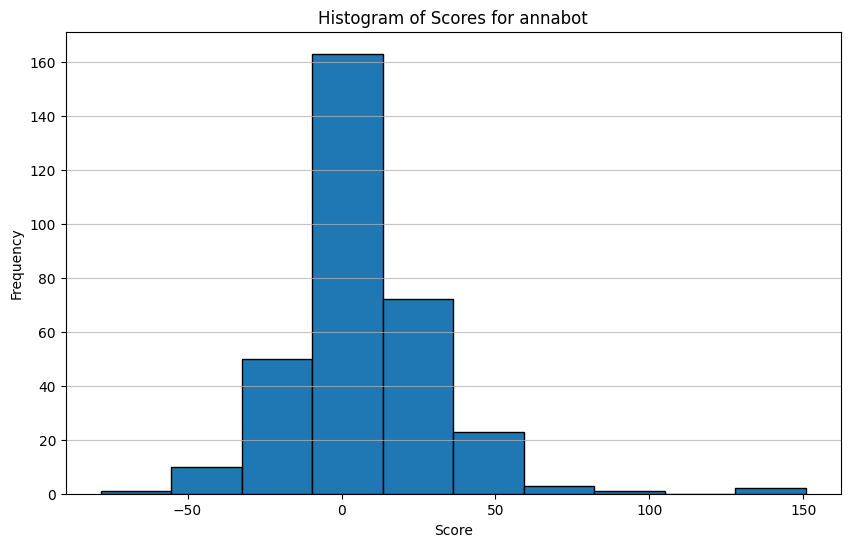

In [44]:
# @title Check specific bot records

bot_name = 'annabot'

df_bot = df_bot_peer_wide[['bot_question_id', 'question_weight', bot_name]]
df_bot = df_bot.dropna()
df_bot = df_bot.reset_index(drop=True)

df_bot['weighted_score'] = df_bot[bot_name] * df_bot['question_weight']

weighted_score = df_bot['weighted_score'].sum()

print(f"Weighted score for {bot_name}: {weighted_score}")

total_score = df_bot[bot_name].sum()

print(f"Total score for {bot_name}: {total_score}\n")

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(df_bot[bot_name], bins=10, edgecolor='black')

# Customize the plot
plt.title(f'Histogram of Scores for {bot_name}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Add grid lines (optional)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [45]:
# Unique values of pro_question_id in df_pro_bot_resolved_questions
df_pro_bot_resolved_questions['pro_question_id'].nunique()

122

In [46]:
# @title Weighted Bot Only Peer, T test

# To choose our top bot team, we only use the questions for which there is no Pro benchmark. (in Q4, there were some bots who ONLY forecasted on questions with Pro benchmark)
no_pro_benchmark = df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['pro_question_id'].isna()]['bot_question_id']

df_bot_only_peer = df_bot_peer[df_bot_peer['bot_question_id'].isin(no_pro_benchmark)]
df_bot_only_peer_wide = make_wide(df_bot_only_peer)

df_W_bot_only_peer_leaderboard = calculate_t_test(df_bot_only_peer_wide, df_bot_only_peer['forecaster'].unique())

df_W_bot_only_peer_leaderboard[['W_ave', 'W_count', 'lower_bound', 'upper_bound']].sort_values(by='lower_bound', ascending=False)

,W_ave,W_count,lower_bound,upper_bound
pgodzinai,13.2,237.6,8.3,18.1
annabot,7.9,201.6,4.7,11.1
histerio,7.8,237.6,3.5,12.2
GreeneiBot2,7.6,237.6,3.3,11.8
MWG,8.8,212.9,3.2,14.4
manticAI,7.5,222.9,2.5,12.5
mf-bot-5,6.2,198.8,-0.4,12.7
Cassie,3.6,224.6,-1.2,8.3
tombot61,6.8,82.5,-1.8,15.4
mf-bot-4,4.6,237.6,-2.7,12.0


In [47]:
# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# exclude bot median for purposes of bot teaming
sorted_df = sorted_df.drop('bot_median', errors='ignore')

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

Top 10 bots:
1. pgodzinai
2. annabot
3. histerio
4. GreeneiBot2
5. MWG
6. manticAI
7. mf-bot-5
8. Cassie
9. tombot61
10. mf-bot-4


In [48]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_pro_bot_resolved_questions[['bot_question_id', 'pro_question_id', 'question_weight', 'resolution']],
    on='bot_question_id',
    how='left'
)

# KEEP ONLY ROWS WHERE PRO_QUESTION_ID IS NA
df_bot_team_forecasts = df_bot_team_forecasts[~df_bot_team_forecasts['pro_question_id'].isna()]

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

# Function to calculate median forecast for a given number of bots
def calculate_median_forecast(df, bots):
    return df[bots].median(axis=1)

# Calculate and add median forecasts for 2 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = calculate_median_forecast(df_bot_team_forecasts, bots_subset)

# Display the first few rows of the updated DataFrame
df_bot_team_forecasts.head()

,bot_question_id,question_weight,resolution,pgodzinai,annabot,histerio,GreeneiBot2,MWG,manticAI,mf-bot-5,...,median_forecast_1_bots,median_forecast_2_bots,median_forecast_3_bots,median_forecast_4_bots,median_forecast_5_bots,median_forecast_6_bots,median_forecast_7_bots,median_forecast_8_bots,median_forecast_9_bots,median_forecast_10_bots
0,28922,1.0,no,0.02,0.0225,0.072,0.118,0.03,NaN,NaN,...,0.02,0.02125,0.0225,0.04725,0.0300,0.0300,0.0300,0.030,0.0300,0.02625
1,28923,1.0,no,0.02,0.0125,0.050,0.010,0.02,NaN,NaN,...,0.02,0.01625,0.0200,0.01625,0.0200,0.0200,0.0200,0.020,0.0200,0.02000
2,28924,1.0,no,0.03,0.1000,0.104,0.068,0.04,NaN,NaN,...,0.03,0.06500,0.1000,0.08400,0.0680,0.0680,0.0680,0.068,0.0680,0.05900
10,28958,1.0,no,0.14,0.2750,0.311,0.380,0.06,NaN,NaN,...,0.14,0.20750,0.2750,0.29300,0.2750,0.2750,0.2750,0.275,0.2750,0.23750
11,28959,1.0,no,0.57,0.5050,0.476,0.492,NaN,NaN,NaN,...,0.57,0.53750,0.5050,0.49850,0.4985,0.4985,0.4985,0.492,0.4985,0.49200


In [49]:
# Sanity check (is it OK that average weighted baseline score is higher than 100?)
a = df_bot_team_forecasts['question_weight'].sum()
b = df_bot_team_forecasts.shape[0] # number of rows in df_bot_team_forecasts
print(f'Sum of weights: {a}, Number of questions: {b}')

Sum of weights: 96.2956, Number of questions: 122


In [50]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

def calculate_weighted_scores(df_bot_team_forecasts, teams):
    # Initialize a dictionary to store the weighted scores for each team
    team_scores = {team: 0 for team in teams}

    # Iterate through each row (question) in the dataframe
    for _, row in df_bot_team_forecasts.iterrows():
        resolution = row['resolution']
        question_weight = row['question_weight']

        # Calculate the baseline score for each team
        for team in teams:
            forecast = row[team]

            # Calculate the baseline score based on the resolution
            if resolution == 'yes':
                baseline_score = np.log2(forecast / 0.5)
            elif resolution == 'no':
                baseline_score = np.log2((1 - forecast) / 0.5)
            else:
                # Skip if resolution is neither 0 nor 1
                continue

            # Calculate the weighted score and add it to the team's total
            weighted_score = baseline_score * question_weight
            team_scores[team] += weighted_score

    # Convert the dictionary to a pandas Series for easier handling
    return pd.Series(team_scores)

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)

# Print nicely - round to 2 decimal places and first column should be just an integer (bot team size)
weighted_scores_print = pd.DataFrame(weighted_scores).reset_index()
weighted_scores_print.columns = ['Bot_Team_Size', 'Weighted_Baseline_Score_for_Bot_Team_Median']
weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'] = weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'].round(2)
weighted_scores_print['Bot_Team_Size'] = weighted_scores_print['Bot_Team_Size'].apply(lambda x: int(x.split('_')[2].split('_')[0]))
weighted_scores_print

,Bot_Team_Size,Weighted_Baseline_Score_for_Bot_Team_Median
0,1,29.04
1,2,28.43
2,3,25.12
3,4,25.03
4,5,26.57
5,6,26.90
6,7,26.36
7,8,26.67
8,9,25.71
9,10,26.27


In [51]:
# Index of top bot team from weighted_scores_print?
winning_bot_team_size = weighted_scores_print.sort_values(by='Weighted_Baseline_Score_for_Bot_Team_Median', ascending=False).head(1)['Bot_Team_Size'].values[0]
top_bot_team = top_10_bots[:winning_bot_team_size]
top_bot_team

['pgodzinai']

In [52]:
# @title Weighted team-vs-pro

# We have our top bot team members.
# Calculate their median forecast on the pro_bot questions.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head score

df_top_bot_forecasts = df_bot_forecasts[['bot_question_id'] + top_bot_team]
df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)

df_pro_median = df_pro_forecasts[['pro_question_id', 'pro_median']]

df_top_bot_pro_forecasts = pd.merge(
    df_pro_bot_resolved_questions,
    df_top_bot_forecasts[['bot_question_id', 'bot_team_median']],
    on='bot_question_id',
    how='left'
)

df_top_bot_pro_forecasts = pd.merge(
    df_top_bot_pro_forecasts,
    df_pro_median,
    on='pro_question_id',
    how='left'
)

# Filter to only those rows where pro_median is not NA
df_top_bot_pro_forecasts = df_top_bot_pro_forecasts.dropna(subset=['pro_median'])

def calculate_head_to_head(row):
    if row['resolution'] == 'yes':
        return 100* np.log(row['bot_team_median'] / row['pro_median'])
    elif row['resolution'] == 'no':
        return 100* np.log((1 - row['bot_team_median']) / (1 - row['pro_median']))
    else:
        return np.nan

# Add the head_to_head column
df_top_bot_pro_forecasts['head_to_head'] = df_top_bot_pro_forecasts.apply(calculate_head_to_head, axis=1)

df_top_bot_pro_forecasts

/tmp/ipykernel_2209775/1628577022.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)


,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head
0,28922,Will a senolytic therapy be approved for comme...,no,2024-10-22 14:30:00,2024-10-22 14:30:00,28887,1.0000,0.02,0.004000,-1.619469
1,28923,Will a nuclear weapon be detonated as an act o...,no,2024-10-22 14:30:00,2024-10-22 14:30:00,28888,1.0000,0.02,0.002500,-1.769945
2,28924,Will a book written by a language model make t...,no,2024-10-22 14:30:00,2024-10-22 14:30:00,28889,1.0000,0.03,0.020000,-1.025650
10,28958,Will IBM lower its Pay-as-you-go quantum compu...,no,2024-10-23 14:30:00,2024-10-23 14:30:00,28942,1.0000,0.14,0.075014,-7.284674
11,28959,Will the Liberal Democratic Party win a majori...,no,2024-10-23 14:30:00,2024-10-23 14:30:00,28943,1.0000,0.57,0.500000,-15.082289
...,...,...,...,...,...,...,...,...,...,...
394,30787,Will Blue Origin launch its New Glenn rocket b...,no,2024-12-14 15:30:00,2024-12-14 15:30:00,30753,1.0000,0.14,0.300000,20.585205
395,30791,Will US airline passenger volume be for the we...,no,2024-12-14 15:30:00,2024-12-14 15:30:00,30757,0.4644,0.12,0.100000,-2.247286
396,30792,Will US airline passenger volume be for the we...,yes,2024-12-14 15:30:00,2024-12-14 15:30:00,30758,0.4644,0.34,0.400000,-16.251893
397,30793,Will US airline passenger volume be for the we...,no,2024-12-14 15:30:00,2024-12-14 15:30:00,30759,0.4644,0.41,0.380000,-4.959694


In [53]:
# Calculate the weighted score for each row
df_top_bot_pro_forecasts['weighted_score'] = df_top_bot_pro_forecasts['head_to_head'] * df_top_bot_pro_forecasts['question_weight']

# Calculate the total weighted score
total_weighted_score = df_top_bot_pro_forecasts['weighted_score'].sum()

# Calculate the sum of weights
total_weight = df_top_bot_pro_forecasts['question_weight'].sum()

# Calculate the weighted total score
weighted_total_score = total_weighted_score / total_weight

print(f"Weighted Total Score: {weighted_total_score:.4f}")

# TK: Interval? Might come later

Weighted Total Score: -8.8021


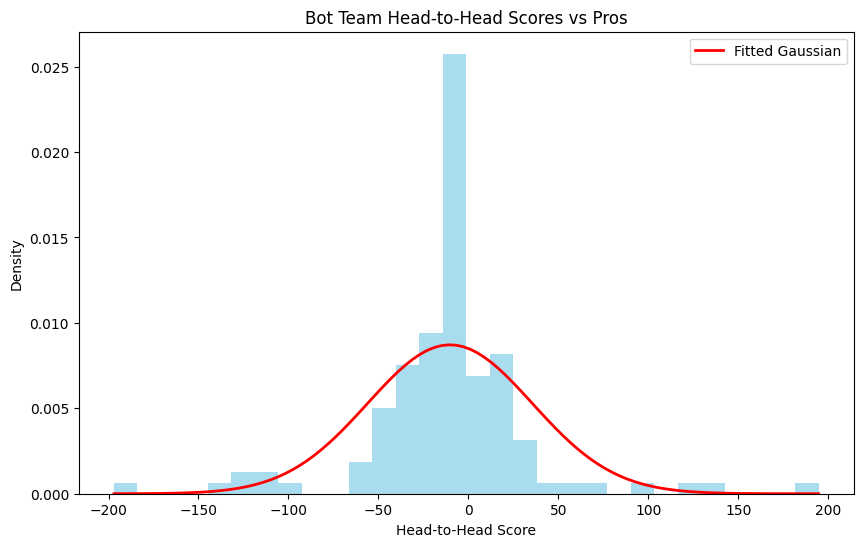

The average of 'head_to_head' is: -10.25


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_top_bot_pro_forecasts is already defined and contains the 'head_to_head' column

# Extract the 'head_to_head' data
data = df_top_bot_pro_forecasts['head_to_head']

# Calculate the mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data, bins=30, density=True, alpha=0.7, color='skyblue')

# Generate points for the fitted Gaussian curve
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mean, std)

# Plot the fitted Gaussian curve
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Gaussian')

# Customize the plot
plt.title('Bot Team Head-to-Head Scores vs Pros')
plt.xlabel('Head-to-Head Score')
plt.ylabel('Density')
plt.legend()

# Add text annotation for the mean
#plt.text(0.95, 0.95, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

# Display the plot
plt.show()

# Print the average
print(f"The average of 'head_to_head' is: {mean:.2f}")

In [55]:

df3 = df_top_bot_pro_forecasts.copy()

df3 = df3[['head_to_head', 'question_weight']]
df3 = df3.dropna()
df3 = df3.reset_index(drop=True)
weighted_score = (df3['head_to_head'] * df3['question_weight']).sum()
weighted_count = df3['question_weight'].sum()
weighted_average = weighted_score / weighted_count
weighted_std_dev = np.sqrt(((df3['head_to_head'] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
std_error = weighted_std_dev / np.sqrt(weighted_count)
t_statistic = (weighted_average - 0) / std_error
if weighted_count > 2:
  t_crit = t_critical_value(weighted_count - 1)
  # 95% confidence that the true mean is between lower and upper bounds
  upper_bound = weighted_average + t_crit * std_error
  lower_bound = weighted_average - t_crit * std_error
  # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
  # Normalization below
  cdf = norm.cdf(t_statistic * 1.96 / t_crit)
else:
  t_crit = np.NaN
  upper_bound = np.NaN
  lower_bound = np.NaN
  cdf = np.NaN

df_bot_team_h2h = pd.DataFrame()

df_bot_team_h2h.loc[bot, 'W_score'] = weighted_score
df_bot_team_h2h.loc[bot, 'W_count'] = weighted_count
df_bot_team_h2h.loc[bot, 'W_ave'] = weighted_average
df_bot_team_h2h.loc[bot, 'W_stdev'] = weighted_std_dev
df_bot_team_h2h.loc[bot, 'std_err'] = std_error
df_bot_team_h2h.loc[bot, 't_stat'] = t_statistic
df_bot_team_h2h.loc[bot, 't_crit'] = t_crit
df_bot_team_h2h.loc[bot, 'upper_bound'] = upper_bound
df_bot_team_h2h.loc[bot, 'lower_bound'] = lower_bound
df_bot_team_h2h.loc[bot, 'cdf'] = cdf * 100

print(df_bot_team_h2h)

             W_score  W_count     W_ave    W_stdev   std_err    t_stat  \
mf-bot-4 -847.603107  96.2956 -8.802096  48.881539  4.981288 -1.767032   

          t_crit  upper_bound  lower_bound       cdf  
mf-bot-4   1.985     1.085761   -18.689953  4.051182  


In [56]:
df_top_bot_pro_forecasts['resolution'].unique()

array(['no', 'yes'], dtype=object)

In [57]:
pd.set_option('display.max_colwidth', 200)

df_sorted = df_top_bot_pro_forecasts.sort_values(by='head_to_head')
# Round to four decimal places and format as percent
df_sorted['bot_team_median'] = df_sorted['bot_team_median'].map("{:.1%}".format)
df_sorted['pro_median'] = df_sorted['pro_median'].map("{:.1%}".format)
df_sorted['head_to_head'] = df_sorted['head_to_head'].round(1)
#df_sorted['resolution'] = df_sorted['resolution'].map({1: 'yes', 0: 'no'})

df_top5 = df_sorted.head(5)
df_bottom5 = df_sorted.tail(5)

print("Top 5:")

df_top5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]

Top 5:


,title,bot_team_median,pro_median,resolution,head_to_head
317,"Will the lowest temperature recorded in Miami, FL over the entire month of December 2024 never be lower than the highest temperature recorded in Anchorage Alaska for the month?",12.0%,86.0%,yes,-196.9
383,"Will the year-over-year increase in prices of homes in Virginia Beach, VA in November 2024 be greater than or equal to 4.0%, according to Zillow?",20.0%,75.0%,yes,-132.2
343,"Will be Donald Trump's net favorability rating on December 27, 2024 be greater than -4?",21.0%,75.0%,yes,-127.3
342,Will New Zealand report <275 whooping cough cases for weeks 51 and 52?,23.0%,78.5%,yes,-122.7
367,"Will New Delhi experience a ""Hazardous"" air quality index for at least one third of the last two weeks of December 2024?",20.0%,60.0%,yes,-109.9


In [58]:
print("\nBottom 5:")

df_bottom5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]


Bottom 5:


,title,bot_team_median,pro_median,resolution,head_to_head
282,Will the Dairy Recall Tracker maintained by the Center for Dairy Research show more than 1 recall for December 2024?,20.0%,62.0%,no,74.4
293,"Will at least one of Andrea Bocelli's concerts at Madison Square Garden on December 18 or 19, 2024 sell out?",36.0%,75.0%,no,94.0
292,Will Nvidia have the largest market cap in the world at the end of 2024?,3.0%,72.0%,no,124.3
339,"Will any more of Trump's announced Cabinet picks drop out before January 1, 2025?",20.0%,80.0%,no,138.6
210,"Will Alabama have 2.0 million or more residents living in drought on December 31, 2024?",37.0%,91.0%,no,194.6


In [59]:
# Cast df_top_bot_pro_forecasts['resolution'] as string - idk why this is necessary but it is
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].astype(pd.StringDtype())
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].map({'yes': 1, 'no': 0})
df_top_bot_pro_forecasts.dtypes

bot_question_id                  Int64
title                           object
resolution                       int64
scheduled_close_time    datetime64[ns]
actual_close_time       datetime64[ns]
pro_question_id                  Int64
question_weight                float64
bot_team_median                float64
pro_median                     float64
head_to_head                   float64
weighted_score                 float64
dtype: object

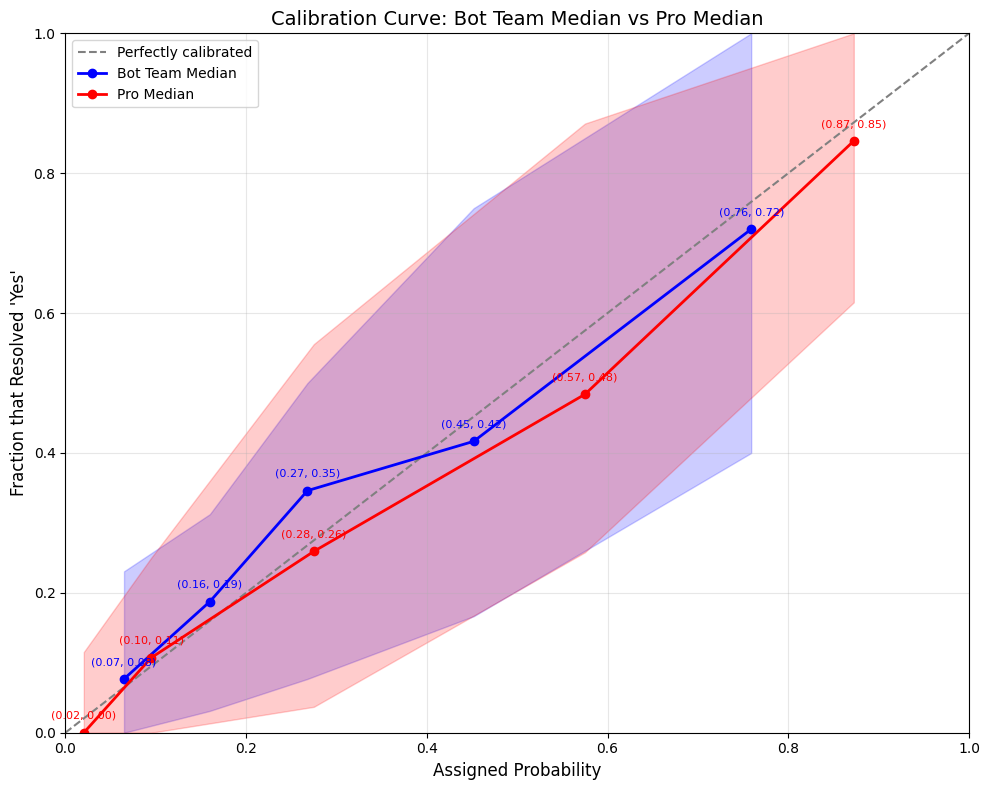

Number of pro forecasts: 122
Number of bot forecasts: 402


In [60]:
from scipy.stats import binom


def calculate_calibration_curve(forecasts: list[float], resolutions: list[int], weights: list[float]) -> dict:
    calibration_curve = []
    # Same number of forecasts in each bin
    quintiles = np.quantile(forecasts, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    bins = []
    for i in range(len(quintiles) - 1):
        bins.append((quintiles[i], quintiles[i + 1]))
    for p_min, p_max in bins:
        resolutions_for_bucket = []
        weights_for_bucket = []
        bin_center = (p_min + p_max) / 2
        for value, weight, resolution in zip(forecasts, weights, resolutions):
            # For the last bin, include the upper bound
            if i == len(bins) - 1:
                if p_min <= value <= p_max:
                    resolutions_for_bucket.append(resolution)
                    weights_for_bucket.append(weight)
            else:
                if p_min <= value < p_max:
                    resolutions_for_bucket.append(resolution)
                    weights_for_bucket.append(weight)
        count = max(len(resolutions_for_bucket), 1)
        average_resolution = (
            np.average(resolutions_for_bucket, weights=weights_for_bucket)
            if sum(weights_for_bucket) > 0
            else None
        )
        lower_confidence_interval = binom.ppf(0.05, count, p_min) / count
        perfect_calibration = binom.ppf(0.50, count, bin_center) / count
        upper_confidence_interval = binom.ppf(0.95, count, p_max) / count

        calibration_curve.append(
            {
                "bin_lower": p_min,
                "bin_upper": p_max,
                "lower_confidence_interval": lower_confidence_interval,
                "average_resolution": average_resolution,
                "upper_confidence_interval": upper_confidence_interval,
                "perfect_calibration": perfect_calibration,
            }
        )

    return {
        "calibration_curve": calibration_curve,
    }


def plot_calibration_curve(df, column_name, label, color):
    y_true = df['resolution']
    y_pred = df[column_name]
    weights = [1.0 for _ in y_true]
    calibration_curve = calculate_calibration_curve(y_pred, y_true, weights)['calibration_curve']
    prob_true = [item['average_resolution'] for item in calibration_curve]
    bin_center = [(item['bin_lower'] + item['bin_upper']) / 2 for item in calibration_curve]
    ci_lower = [item['lower_confidence_interval'] for item in calibration_curve]
    ci_upper = [item['upper_confidence_interval'] for item in calibration_curve]

    plt.plot(bin_center, prob_true, marker='o', linewidth=2, label=label, color=color)
    plt.fill_between(bin_center, ci_lower, ci_upper, alpha=0.2, color=color)
    for x, y in zip(bin_center, prob_true):
        if x is None or y is None:
            continue
        plt.annotate(f'({x:.2f}, {y:.2f})',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    color=color,
                    fontsize=8)


# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title('Calibration Curve: Bot Team Median vs Pro Median', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()
print(f"Number of pro forecasts: {len(df_top_bot_pro_forecasts)}")
print(f"Number of bot forecasts: {len(df_bot_forecasts)}")

In [61]:
import numpy as np
import pandas as pd

# Assuming df_top_bot_pro_forecasts is already defined

def calculate_confidence(predictions, outcomes):
    """
    Calculate over- or under-confidence for a set of predictions.

    :param predictions: Series of predicted probabilities
    :param outcomes: Series of actual outcomes (0 or 1)
    :return: Confidence score (positive for overconfidence, negative for underconfidence)
    """
    # Bin predictions into 10 equally spaced bins
    bins = pd.cut(predictions, bins=10)

    # Calculate mean prediction and actual outcome for each bin
    grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)
    mean_prediction = grouped['prediction'].mean()
    mean_outcome = grouped['outcome'].mean()

    # Calculate the difference between mean prediction and mean outcome
    confidence_diff = mean_prediction - mean_outcome

    # Return the average difference (excluding NaN values)
    return np.nanmean(confidence_diff)

# Calculate confidence scores for bot_team_median and pro_median
bot_confidence = calculate_confidence(df_top_bot_pro_forecasts['bot_team_median'], df_top_bot_pro_forecasts['resolution'])
pro_confidence = calculate_confidence(df_top_bot_pro_forecasts['pro_median'], df_top_bot_pro_forecasts['resolution'])

print(f"Bot team confidence score: {bot_confidence:.4f}")
print(f"Pro team confidence score: {pro_confidence:.4f}")

# Interpret the results
def interpret_confidence(score):
    if score > 0:
        return f"Overconfident by {score:.4f}"
    elif score < 0:
        return f"Underconfident by {abs(score):.4f}"
    else:
        return "Perfectly calibrated"

print(f"Bot team is {interpret_confidence(bot_confidence)}")
print(f"Pro team is {interpret_confidence(pro_confidence)}")

Bot team confidence score: 0.0002
Pro team confidence score: 0.0221
Bot team is Overconfident by 0.0002
Pro team is Overconfident by 0.0221


/tmp/ipykernel_2209775/3215770322.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)


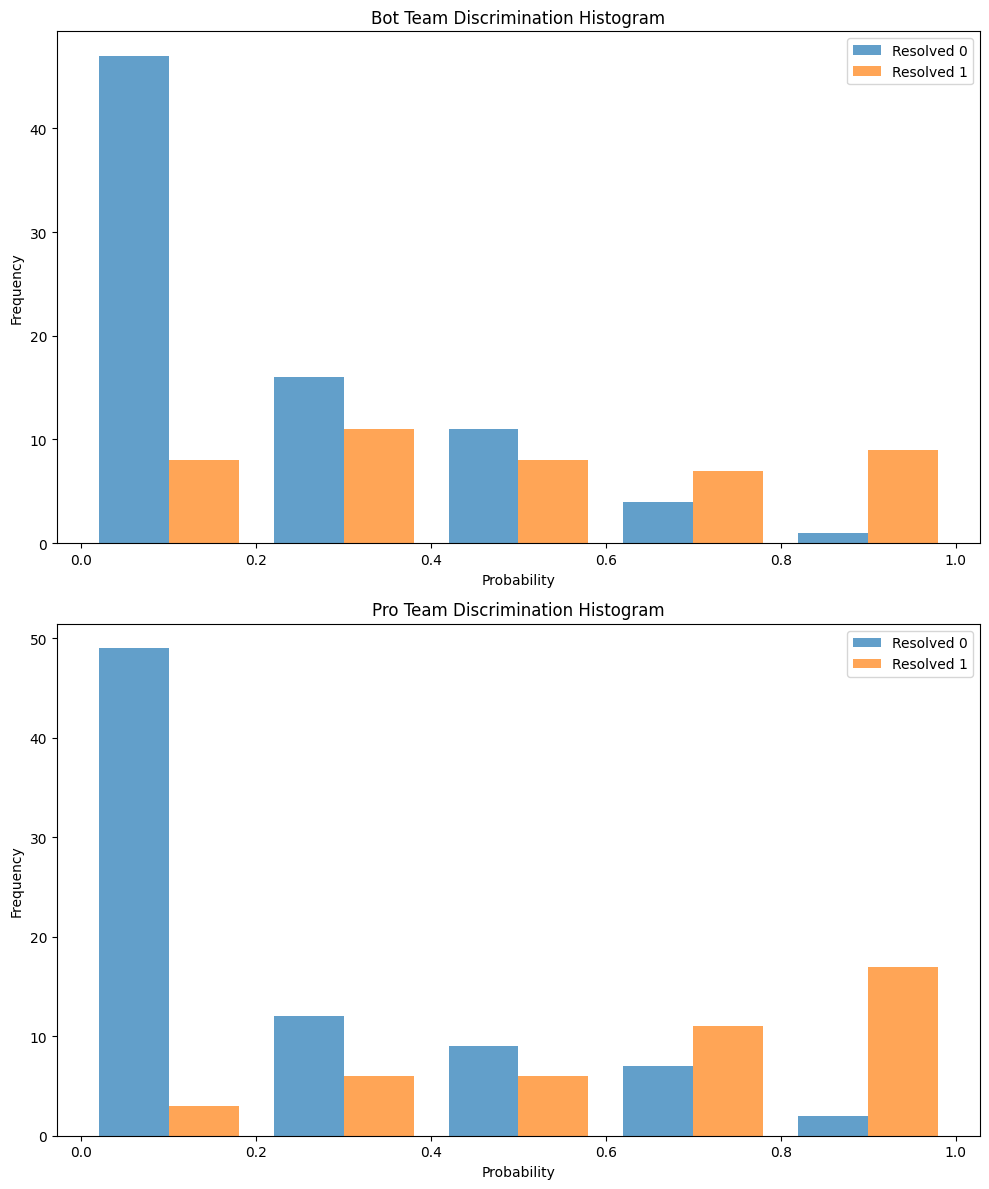

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_top_bot_pro_forecasts is already loaded
# If not, you would load it here:
# df_top_bot_pro_forecasts = pd.read_csv('your_data.csv')

def create_discrimination_histogram(df, bot_col, pro_col, resolution_col):
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Define bin edges
    #bins = np.linspace(0, 1, 11)
    bins = np.linspace(0, 1, 6)

    # Bot team histogram
    ax1.hist([df[df[resolution_col] == 0][bot_col],
              df[df[resolution_col] == 1][bot_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax1.set_title('Bot Team Discrimination Histogram')
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Pro team histogram
    ax2.hist([df[df[resolution_col] == 0][pro_col],
              df[df[resolution_col] == 1][pro_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax2.set_title('Pro Team Discrimination Histogram')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and column names
create_discrimination_histogram(df_top_bot_pro_forecasts,
                                'bot_team_median',
                                'pro_median',
                                'resolution')

In [63]:
# Calculate average forecasts for resolved 1 and 0 for bots
bot_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['bot_team_median'].mean()
bot_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['bot_team_median'].mean()

# Calculate average forecasts for resolved 1 and 0 for pros
pro_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['pro_median'].mean()
pro_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['pro_median'].mean()

# Calculate the differences
bot_difference = bot_avg_1 - bot_avg_0
pro_difference = pro_avg_1 - pro_avg_0

print(f"Bot average forecast difference (1 - 0): {bot_difference:.4f}")
print(f"Pro average forecast difference (1 - 0): {pro_difference:.4f}")

# Calculate the difference between pro and bot differences
pro_bot_difference = pro_difference - bot_difference
print(f"Difference between pro and bot differences: {pro_bot_difference:.4f}")

Bot average forecast difference (1 - 0): 0.2652
Pro average forecast difference (1 - 0): 0.4361
Difference between pro and bot differences: 0.1709


In [64]:
# TK: Ask Tom for scope sensitivity questions?

# Assuming df_top_bot_pro_forecasts is already loaded

if False:

    def get_forecast(question_id):
        forecast = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == question_id]['bot_team_median'].values
        return forecast[0] if len(forecast) > 0 else np.nan

    def process_scope_questions(bot_scope_questions):
        scope_ratios = []

        for question_tuple in bot_scope_questions:
            forecasts = [get_forecast(qid) for qid in question_tuple]

            print(f"Forecasts for questions {question_tuple}: {forecasts}")

            if not any(np.isnan(forecasts)):
                scope_ratio = forecasts[0] / (forecasts[1] + forecasts[2])
                print(f"Scope ratio: {scope_ratio:.4f}")
                scope_ratios.append(scope_ratio)
            else:
                print("Unable to calculate scope ratio due to missing forecast(s)")

            print()  # Empty line for readability

        return scope_ratios

    # Process the bot_scope_questions
    scope_ratios = process_scope_questions(bot_scope_questions)

    # Calculate and print the average scope ratio
    if scope_ratios:
        average_scope_ratio = sum(scope_ratios) / len(scope_ratios)
        print(f"Average scope ratio: {average_scope_ratio:.4f}")
    else:
        print("No valid scope ratios to average")

In [65]:
# Calculate weighted number of 1 resolutions
weighted_ones = np.sum(
    df_top_bot_pro_forecasts['resolution'] *
    df_top_bot_pro_forecasts['question_weight']
)

# Calculate weighted number of 0 resolutions
weighted_zeros = np.sum(
    (1 - df_top_bot_pro_forecasts['resolution']) *
    df_top_bot_pro_forecasts['question_weight']
)

print(f"Weighted number of 1 resolutions: {weighted_ones}")
print(f"Weighted number of 0 resolutions: {weighted_zeros}")

print(f"Average 1 resolutions: {weighted_ones / (weighted_zeros + weighted_ones)}")

Weighted number of 1 resolutions: 33.2467
Weighted number of 0 resolutions: 63.04889999999999
Average 1 resolutions: 0.3452566887791343


CP COMPARISON

In [66]:
## CP COMPARISON (LUKE: LOOK HERE DOWN)

cp = pd.read_csv('https://data.heroku.com/dataclips/xwbtczmsuszvlbrhdifhsilplfxf.csv')
cp.rename(columns={'post_id': 'cp_post_id', 'question_id': 'cp_question_id'}, inplace=True)

bot_cp_id = pd.read_csv('bot_to_main_feed_ids.csv')
                     
# Merge these on cp_question_id
df_bot_cp = pd.merge(bot_cp_id, cp, on='cp_post_id', how='right')

df_bot_cp = df_bot_cp[df_bot_cp['bot_question_id'].notnull()]
df_bot_cp['bot_question_id'] = df_bot_cp['bot_question_id'].astype(int)

# Evaluate cp_reveal_time, start_time, and end_time as datetime objects
df_bot_cp['cp_reveal_time'] = pd.to_datetime(df_bot_cp['cp_reveal_time'])
df_bot_cp['start_time'] = pd.to_datetime(df_bot_cp['start_time'])
df_bot_cp['end_time'] = pd.to_datetime(df_bot_cp['end_time'])

# For each group of (bot_question_id, question_title, cp_reveal_time), take only the row with the start_time closest to (BUT LESS THAN) cp_reveal_time
df_bot_cp = df_bot_cp.sort_values(by=['bot_question_id', 'cp_reveal_time', 'start_time'])
df_bot_cp = df_bot_cp[df_bot_cp['start_time'] < df_bot_cp['cp_reveal_time']]
df_bot_cp = df_bot_cp.drop_duplicates(subset=['bot_question_id', 'cp_reveal_time'], keep='last')

# Convert string representation of lists to actual lists
df_bot_cp['forecast_values'] = df_bot_cp['forecast_values'].str.strip('[]').str.split(',').apply(lambda x: [float(i.strip()) for i in x])

# How many rows?
print(f"Number of rows: {len(df_bot_cp)}")

Number of rows: 134


In [67]:
pd.set_option('display.max_colwidth', 250)

In [68]:
# Break down by types - "group" (multiple choice; my bad), "binary" and "numeric"

# Group questions are the ones that have NON-EMPTY lists in the options column
groups = df_bot_cp[df_bot_cp['type'] == 'multiple_choice']
groups['options'] = groups['options'].str.strip('[]').str.split(',').apply(lambda x: [i.strip().strip("'") for i in x])

binaries = df_bot_cp[df_bot_cp['type'] == 'binary']

numerics = df_bot_cp[df_bot_cp['type'] == 'numeric']

keep_cols = ['bot_question_id', 'question_title', 'title', 'cp_reveal_time', 'type', 'cp_question_id', 'cp_post_id', 'forecast_values']

/tmp/ipykernel_2209775/3903723240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups['options'] = groups['options'].str.strip('[]').str.split(',').apply(lambda x: [i.strip().strip("'") for i in x])


In [69]:
# Find and store problematic index
problematic_idx = None
for idx, row in groups.iterrows():
   if len(row['forecast_values']) != len(row['options']):
       problematic_idx = idx
       break

# Fix the specific row using stored index
if problematic_idx is not None:
   groups.at[problematic_idx, 'options'] = [
       'Low',
       'Moderate (or medium or equivalent)',
       'High (or above such as Very High)'
   ]

In [70]:
groups_exploded = groups.explode(['options', 'forecast_values'])
groups_exploded['options'] = groups_exploded['options'].str.strip('"')

# Need to filter to the rows that correspond to the right option
filtered_rows = []

# For each bot_question_id
for bot_question_id in groups_exploded['bot_question_id'].unique():
    # Get all rows for this bot_question_id
    question_group = groups_exploded[groups_exploded['bot_question_id'] == bot_question_id]
    
    # Get the question title
    question_title = question_group['question_title'].iloc[0]
    
    # Function to check if option matches question title
    def option_matches(row):
        option = row['options']
        if option in question_title:
            return True
        # Handle "X or Y" vs "X-Y" format
        if '-' in option:
            start, end = option.split('-')
            or_format = f"{start} or {end}"
            return or_format in question_title
        return False
    
    # Find rows where the question title contains the option (with format handling)
    matching_rows = question_group[question_group.apply(option_matches, axis=1)]
    
    # If we found a matching row, add the first one to our filtered rows
    if not matching_rows.empty:
        filtered_rows.append(matching_rows.iloc[0])

# Combine all filtered rows into a DataFrame
groups_filtered = pd.DataFrame(filtered_rows)

# Print check
print(f"Original unique bot_question_ids: {len(groups_exploded['bot_question_id'].unique())}")
print(f"Filtered unique bot_question_ids: {len(groups_filtered['bot_question_id'].unique())}")

Original unique bot_question_ids: 21
Filtered unique bot_question_ids: 21


In [71]:
groups_filtered[['bot_question_id', 'question_title', 'title', 'options']].head(3)

,bot_question_id,question_title,title,options
6912,29165,"Will CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2025, be ""Low""?","What will be CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2026?",Low
4777,29356,Will Gukesh Dommaraju win the 2024 World Chess Championship?,Who will win the 2024 World Chess Championship?,Gukesh Dommaraju
3634,29636,"Will 0-3 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",0-3


In [72]:
# For BINARIES: Interpret forecast_values as lists and take the first element from each
binaries['forecast_values'] = binaries['forecast_values'].apply(lambda x: x[0])

/tmp/ipykernel_2209775/3601554287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binaries['forecast_values'] = binaries['forecast_values'].apply(lambda x: x[0])


In [73]:
numerics[['bot_question_id', 'question_title']]

,bot_question_id,question_title
14602,29163,"Will the lowest COVID-19 hospitalization rate from October 5, 2024, to January 4, 2025, be below 2.0?"
1521,29349,"Will it rain more than 100mm in Brasília, Brazil in December 2024?"
1522,29350,"Will it rain more than 150mm in Brasília, Brazil in December 2024?"
1523,29351,"Will it rain more than 200mm in Brasília, Brazil in December 2024?"
19251,29353,Will the US State Department approve more than 20 arms sales globally in the fourth quarter of 2024?
19252,29354,Will the US State Department approve more than 25 arms sales globally in the fourth quarter of 2024?
23841,29362,"Will there be greater than or equal to 3,900 emojis on December 31, 2024?"
14834,29461,"Will the weekly total number of influenza hospitalizations for the United States for the week of Nov 23, 2024 be more than 2,000?"
14835,29462,"Will the weekly total number of influenza hospitalizations for the United States for the week of Dec 7, 2024 be more than 2,000?"
25223,29463,"Will the CDC report more than 80% of the tested influenza sequences as influenza A during the 2024-25 season through the week ending Dec 21, 2024?"


In [74]:
# NUMERICS ARE TRICKY

# How long is each list in forecast_values?
numerics['cdf_size'] = numerics['forecast_values'].apply(len)

# Forbes Real-Time Billionaires highest other net worth (for Elon Musk question)
bezos = 240 # TK: Check what value was actually used for resolution

# Need to extract thresholds from binary versions of the numeric questions. TK: Could use another pair of eyes
thresholds = {
   29163: ('less', 2.0),        # COVID hospitalizations
   29349: ('greater', 100),     # Brasilia rain
   29350: ('greater', 150),     # Brasilia rain 
   29351: ('greater', 200),     # Brasilia rain
   29353: ('greater', 20),      # Arms sales
   29354: ('greater', 25),      # Arms sales
   29362: ('greater', 3900),    # Emojis
   29461: ('greater', 2000),    # Influenza hospitalizations
   29462: ('greater', 2000),    # Influenza hospitalizations
   29463: ('greater', 80),      # CDC influenza A
   29566: ('less', 17.0),       # China unemployment Oct
   29567: ('complicated', 0.0), # China unemployment Oct
   29568: ('complicated', 0.0), # China unemployment Oct
   29569: ('greater', 19.0),    # China unemployment Oct
   29642: ('less', bezos),        # Elon Musk net worth
   29643: ('complicated', 0.0), # Elon Musk net worth
   29644: ('complicated', 0.0), # Elon Musk net worth
   29645: ('complicated', 0.0), # Elon Musk net worth
   29646: ('greater', bezos+100),     # Elon Musk net worth
   29836: ('less', 17.0),       # China unemployment Nov
   29837: ('complicated', 0.0), # China unemployment Nov
   29838: ('complicated', 0.0), # China unemployment Nov
   29839: ('greater', 19.0),    # China unemployment Nov
   29836: ('greater', 375),     # NZ whooping cough
   30578: ('complicated', 0.0), # NZ whooping cough
   30579: ('less', 275),        # NZ whooping cough
   30440: ('greater', -4),      # Trump favorability
   30441: ('complicated', 0.0), # Trump favorability
   30442: ('less', -6),         # Trump favorability
   30583: ('greater', 7400),    # CAC 40
   30584: ('complicated', 0.0), # CAC 40
   30585: ('less', 7200),       # CAC 40
   29462: ('greater', 2000),    # Influenza hospitalizations
   29462: ('greater', 2000)     # Influenza hospitalizations
}

# Apply that dictionary and make a 'binary_version_tuple' column
numerics['binary_version_tuple'] = numerics['bot_question_id'].map(thresholds)

numerics.dtypes

/tmp/ipykernel_2209775/13775196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics['cdf_size'] = numerics['forecast_values'].apply(len)
/tmp/ipykernel_2209775/13775196.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics['binary_version_tuple'] = numerics['bot_question_id'].map(thresholds)


bot_question_id                       int64
question_title                       object
cp_reveal_time          datetime64[ns, UTC]
cp_post_id                            int64
cp_question_id                        int64
forecast_values                      object
means                                object
centers                              object
method                               object
start_time              datetime64[ns, UTC]
end_time                datetime64[ns, UTC]
title                                object
options                              object
range_min                           float64
range_max                           float64
zero_point                          float64
type                                 object
cdf_size                              int64
binary_version_tuple                 object
dtype: object

In [75]:
numerics[['binary_version_tuple', 'forecast_values']].head()

,binary_version_tuple,forecast_values
14602,"(less, 2.0)","[0.009589270398489818, 0.009897947458672568, 0.010216317282116144, 0.010544840808707996, 0.010884004835728184, 0.01123432331524064, 0.011596338585872513, 0.011970622485604474, 0.012357777277599463, 0.012758436305452543, 0.013173264279849014, 0.01..."
1521,"(greater, 100)","[0.0416546733259909, 0.042663084228944485, 0.04370527246112732, 0.04478341825796766, 0.045899906810896327, 0.04705734312465301, 0.04825856533724631, 0.0495066554023696, 0.050804945726566686, 0.05215702000665339, 0.053566706140123314, 0.0550380587..."
1522,"(greater, 150)","[0.0416546733259909, 0.042663084228944485, 0.04370527246112732, 0.04478341825796766, 0.045899906810896327, 0.04705734312465301, 0.04825856533724631, 0.0495066554023696, 0.050804945726566686, 0.05215702000665339, 0.053566706140123314, 0.0550380587..."
1523,"(greater, 200)","[0.0416546733259909, 0.042663084228944485, 0.04370527246112732, 0.04478341825796766, 0.045899906810896327, 0.04705734312465301, 0.04825856533724631, 0.0495066554023696, 0.050804945726566686, 0.05215702000665339, 0.053566706140123314, 0.0550380587..."
19251,"(greater, 20)","[0.0, 0.0002471962836609541, 0.0004994833813039071, 0.0007570051994605769, 0.0010199111269140104, 0.0012883563788852277, 0.0015625023718122113, 0.0018425171317163773, 0.0021285757394289367, 0.0024208608162454262, 0.0027195630538907065, 0.00302488..."


In [76]:
# CODE FROM LUKE, REFACTORED BY CHATGPT

def string_location_to_scaled_location(string_location: str, question_row: pd.Series) -> float:
    if string_location in ["ambiguous", "annulled"]:
        raise ValueError("Cannot convert ambiguous or annulled to any real locations")

    question_type = question_row["type"]

    if question_type == "binary":
        return 1.0 if string_location == "yes" else 0.0

    if question_type == "multiple_choice":
        return float(question_row["options"].index(string_location))

    # continuous
    if string_location == "below_lower_bound":
        return question_row["range_min"] - 1.0
    if string_location == "above_upper_bound":
        return question_row["range_max"] + 1.0

    if question_type == "date":
        return datetime.fromisoformat(string_location).timestamp()

    # question.type == "numeric"
    return float(string_location)

def scaled_location_to_unscaled_location(scaled_location: float, question_row: pd.Series) -> float:
    question_type = question_row["type"]

    if question_type in ["binary", "multiple_choice"]:
        return scaled_location

    zero_point = question_row.get("zero_point")
    range_max = question_row["range_max"]
    range_min = question_row["range_min"]

    if zero_point is not None:
        deriv_ratio = (range_max - zero_point) / max((range_min - zero_point), 1e-7)
        return (
            np.log((scaled_location - range_min) * (deriv_ratio - 1) + (range_max - range_min))
            - np.log(range_max - range_min)
        ) / np.log(deriv_ratio)

    return (scaled_location - range_min) / (range_max - range_min)

def nominal_location_to_cdf_location(
    nominal_location: str | float,
    question_data: dict,
) -> float:
    """Takes a location in nominal format (e.g. 123, "123",
    or datetime in iso format) and scales it to metaculus's
    "internal representation" range [0,1] incorporating question scaling"""
    if question_data["type"] == "date":
        scaled_location = datetime.fromisoformat(nominal_location).timestamp()
    else:
        scaled_location = float(nominal_location)
    # Unscale the value to put it into the range [0,1]
    range_min = question_data["range_min"]
    range_max = question_data["range_max"]
    zero_point = question_data["zero_point"]
    if ~np.isnan(zero_point) and (zero_point is not None):
        # logarithmically scaled question
        deriv_ratio = (range_max - zero_point) / (range_min - zero_point)
        unscaled_location = (
            np.log(
                (scaled_location - range_min) * (deriv_ratio - 1)
                + (range_max - range_min)
            )
            - np.log(range_max - range_min)
        ) / np.log(deriv_ratio)
    else:
        # linearly scaled question
        unscaled_location = (scaled_location - range_min) / (range_max - range_min)
    return unscaled_location

def get_cdf_at(cdf, unscaled_location) -> float:
    """CDF is a list of values, unscaled_location is a float
    with 0 meaning lower bound and 1 meaning upper bound"""
    if unscaled_location <= 0:
        return cdf[0]
    if unscaled_location >= 1:
        return cdf[-1]
    index_scaled_location = unscaled_location * (len(cdf) - 1)
    if index_scaled_location.is_integer():
        return cdf[int(index_scaled_location)]
    # linear interpolation step
    left_index = int(index_scaled_location) # This is the floor, which is what we want
    right_index = left_index + 1
    left_value = cdf[left_index]
    right_value = cdf[right_index]
    return left_value + (right_value - left_value) * (
        index_scaled_location - left_index
    )

#def unscaled_location_to_bucket_index(unscaled_location: float, question_row: pd.Series) -> int:
    #question_type = question_row["type"]

    #if question_type in ["binary", "multiple_choice"]:
        #return int(unscaled_location)

    ## continuous
    #if unscaled_location < 0:
        #return 0
    #if unscaled_location > 1:
        #return question_row["cdf_size"]
    #if unscaled_location == 1:
        #return question_row["cdf_size"] - 1

    #return max(int(unscaled_location * (question_row["cdf_size"] - 1) + 1 - 1e-10), 1)

#def string_location_to_unscaled_location(string_location: str, question_row: pd.Series) -> float:
    #if string_location in [None, "ambiguous", "annulled"]:
        #import pdb; pdb.set_trace()
        #return None

    #scaled_location = string_location_to_scaled_location(string_location, question_row)
    #import pdb; pdb.set_trace()
    #return scaled_location_to_unscaled_location(scaled_location, question_row)

#def string_location_to_bucket_index(string_location: str, question_row: pd.Series) -> int | None:
    #if string_location in [None, "ambiguous", "annulled"]:
        #return None

    #unscaled_location = string_location_to_unscaled_location(string_location, question_row)
    #return unscaled_location_to_bucket_index(unscaled_location, question_row)

In [77]:
# Unique values of binary_version_tuple
unique_tuples = numerics['binary_version_tuple'].unique()
unique_tuples

array([('less', 2.0), ('greater', 100), ('greater', 150),
       ('greater', 200), ('greater', 20), ('greater', 25),
       ('greater', 3900), ('greater', 2000), ('greater', 80), nan,
       ('less', 17.0), ('complicated', 0.0), ('greater', 19.0),
       ('less', 240), ('greater', 340), ('greater', 375), ('greater', -4),
       ('less', -6), ('greater', 7400), ('less', 7200)], dtype=object)

In [78]:
# Save cdf's for the complicated ones (we will overwrite forecast_values)
numerics['cdf'] = numerics['forecast_values']

def process_forecast_values(df):
    """
    Adds a new column 'bucket_forecast_value' to the DataFrame.
    Handles 'binary_version_tuple' and applies logic for 'less', 'greater', and 'complicated'.

    :param df: DataFrame with 'binary_version_tuple', 'forecast_values', and other question-specific columns
    :return: Updated DataFrame with 'bucket_forecast_value' column added
    """
    def compute_bucket_forecast_value(row):
        # Handle binary_version_tuple gracefully
        if pd.isna(row['binary_version_tuple']) or not isinstance(row['binary_version_tuple'], (list, tuple)):
            return None
        
        # Extract the first and second elements of the tuple
        comparison_type = row['binary_version_tuple'][0]
        string_location = row['binary_version_tuple'][1]
        
        # Skip if comparison_type is 'complicated'
        if comparison_type == 'complicated':
            return None
        
        # Compute forecast_value using the extracted string_location
        forecast_value = get_cdf_at(row['cdf'], nominal_location_to_cdf_location(string_location, row))
        
        # Apply logic based on comparison_type
        if comparison_type == 'less':
            return forecast_value
        elif comparison_type == 'greater':
            return 1 - forecast_value
        
        return None

    # Apply the function to each row and overwrite forecast_value (currently contains cdf, which we no longer need)
    df['forecast_values'] = df.apply(compute_bucket_forecast_value, axis=1)
    return df

numerics = process_forecast_values(numerics)

/tmp/ipykernel_2209775/1426049180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics['cdf'] = numerics['forecast_values']
/tmp/ipykernel_2209775/1426049180.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forecast_values'] = df.apply(compute_bucket_forecast_value, axis=1)


In [79]:
## Doing the "between" numerics one by one by bot_question_id

def cdf_between(row, cdf, lower_bound, upper_bound):
  a = get_cdf_at(cdf, nominal_location_to_cdf_location(lower_bound, row))
  b = get_cdf_at(cdf, nominal_location_to_cdf_location(upper_bound, row))
  numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = b - a

# 29503: Waymo exactly 4, i.e. between 3.5 and 4.5 on continuous question
row = numerics[numerics['bot_question_id'] == 29503].iloc[0]
cdf_between(row, row['cdf'], 3.5, 4.5)

# 29567: China youth unemployment > 17.0 and less than 18.0
row = numerics[numerics['bot_question_id'] == 29567].iloc[0]
cdf_between(row, row['cdf'], 17.0, 18.0)

# 29568: China youth unemployment > 18.0 and less than 19.0
row = numerics[numerics['bot_question_id'] == 29568].iloc[0]
cdf_between(row, row['cdf'], 18.0, 19.0)

# 29643: Elon Musk net worth > 240 and less than 280
row = numerics[numerics['bot_question_id'] == 29643].iloc[0]
cdf_between(row, row['cdf'], bezos, bezos+40)

# 29644: Elon Musk net worth > 280 and less than 310
row = numerics[numerics['bot_question_id'] == 29644].iloc[0]
cdf_between(row, row['cdf'], bezos+40, bezos+70)

# 29645: Elon Musk net worth > 310 and less than 340
row = numerics[numerics['bot_question_id'] == 29645].iloc[0]
cdf_between(row, row['cdf'], bezos+70, bezos+100)

# 29837: China youth unemployment > 17.0 and less than 18.0
row = numerics[numerics['bot_question_id'] == 29837].iloc[0]
cdf_between(row, row['cdf'], 17.0, 18.0)

# 29838: China youth unemployment > 18.0 and less than 19.0
row = numerics[numerics['bot_question_id'] == 29838].iloc[0]
cdf_between(row, row['cdf'], 18.0, 19.0)

# 30281: Waymo exactly 4, i.e. between 3.5 and 4.5 on continuous question
row = numerics[numerics['bot_question_id'] == 30281].iloc[0]
cdf_between(row, row['cdf'], 3.5, 4.5)

# 30437: New Zealand >375 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30437].iloc[0]
cdf_between(row, row['cdf'], 375, 400)

# 30438: New Zealand >275 and less than 375 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30438].iloc[0]
cdf_between(row, row['cdf'], 275, 375)

# 30439: New Zealand less than 275 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30439].iloc[0]
cdf_between(row, row['cdf'], 250, 275)

# 30441: Trump net favorabilty > -6 and less than -4
row = numerics[numerics['bot_question_id'] == 30441].iloc[0]
cdf_between(row, row['cdf'], -6, -4)

# 30584: CAC 40 > 7200 and less than 7400
row = numerics[numerics['bot_question_id'] == 30584].iloc[0]
cdf_between(row, row['cdf'], 7200, 7400)

In [80]:
# Rows where forecast_values is NaN in numerics? TK: Tom do these make sense (were they annulled or something)
numerics[numerics['forecast_values'].isna()]

,bot_question_id,question_title,cp_reveal_time,cp_post_id,cp_question_id,forecast_values,means,centers,method,start_time,end_time,title,options,range_min,range_max,zero_point,type,cdf_size,binary_version_tuple,cdf
16086,30791,"Will US airline passenger volume be for the week of Christmas through New Years Eve 2024 be greater than 19 million, according to the TSA?",2024-12-14 15:30:00+00:00,28860,28815,NaN,NaN,[0.6281774081057879],recency_weighted,2024-12-14 07:32:50.852496+00:00,2024-12-14 20:40:50.788961+00:00,"What will US airline passenger volume be for the week of Christmas through New Years Eve 2024, according to the TSA?",[],14.0,20.0,NaN,numeric,201,NaN,"[0.0072585921666485816, 0.007536009620194083, 0.007823545124108853, 0.00812175035759142, 0.008431202062329871, 0.00875250120946771, 0.009086271217656748, 0.009433155937751537, 0.009793816758207284, 0.010168929144136044, 0.010559178117511272, 0.01..."
16087,30792,"Will US airline passenger volume be for the week of Christmas through New Years Eve 2024 be greater than or equal to 18 million and less than or equal to 19 million, according to the TSA?",2024-12-14 15:30:00+00:00,28860,28815,NaN,NaN,[0.6281774081057879],recency_weighted,2024-12-14 07:32:50.852496+00:00,2024-12-14 20:40:50.788961+00:00,"What will US airline passenger volume be for the week of Christmas through New Years Eve 2024, according to the TSA?",[],14.0,20.0,NaN,numeric,201,NaN,"[0.0072585921666485816, 0.007536009620194083, 0.007823545124108853, 0.00812175035759142, 0.008431202062329871, 0.00875250120946771, 0.009086271217656748, 0.009433155937751537, 0.009793816758207284, 0.010168929144136044, 0.010559178117511272, 0.01..."
16088,30793,"Will US airline passenger volume be for the week of Christmas through New Years Eve 2024 be greater than 17 million and less than 18 million, according to the TSA?",2024-12-14 15:30:00+00:00,28860,28815,NaN,NaN,[0.6281774081057879],recency_weighted,2024-12-14 07:32:50.852496+00:00,2024-12-14 20:40:50.788961+00:00,"What will US airline passenger volume be for the week of Christmas through New Years Eve 2024, according to the TSA?",[],14.0,20.0,NaN,numeric,201,NaN,"[0.0072585921666485816, 0.007536009620194083, 0.007823545124108853, 0.00812175035759142, 0.008431202062329871, 0.00875250120946771, 0.009086271217656748, 0.009433155937751537, 0.009793816758207284, 0.010168929144136044, 0.010559178117511272, 0.01..."
16089,30794,"Will US airline passenger volume be for the week of Christmas through New Years Eve 2024 be less than or equal to 17 million, according to the TSA?",2024-12-14 15:30:00+00:00,28860,28815,NaN,NaN,[0.6281774081057879],recency_weighted,2024-12-14 07:32:50.852496+00:00,2024-12-14 20:40:50.788961+00:00,"What will US airline passenger volume be for the week of Christmas through New Years Eve 2024, according to the TSA?",[],14.0,20.0,NaN,numeric,201,NaN,"[0.0072585921666485816, 0.007536009620194083, 0.007823545124108853, 0.00812175035759142, 0.008431202062329871, 0.00875250120946771, 0.009086271217656748, 0.009433155937751537, 0.009793816758207284, 0.010168929144136044, 0.010559178117511272, 0.01..."


In [81]:
numerics = numerics[keep_cols]
binaries = binaries[keep_cols]
groups_filtered = groups_filtered[keep_cols]

In [82]:
# Now we can merge all back together into.... df_bot_cp_exploded; keep only the relevant columns, i.e. 'bot_question_id', 'cp_question_id', 'cp_post_id', 'forecast_values'
df_bot_cp_exploded = pd.concat([groups_filtered, binaries, numerics])
df_bot_cp_exploded.head()

,bot_question_id,question_title,title,cp_reveal_time,type,cp_question_id,cp_post_id,forecast_values
6912,29165,"Will CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2025, be ""Low""?","What will be CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2026?",2024-10-29 14:30:00+00:00,multiple_choice,29003,29090,0.848501
4777,29356,Will Gukesh Dommaraju win the 2024 World Chess Championship?,Who will win the 2024 World Chess Championship?,2024-11-02 14:30:00+00:00,multiple_choice,28546,28546,0.720000
3634,29636,"Will 0-3 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.016292
3635,29637,"Will 4 or 5 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.054523
3636,29638,"Will 6 or 7 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.098215


In [83]:
# Show me rows that are 0 in forecast_values
df_bot_cp_exploded[df_bot_cp_exploded['forecast_values'] == 0]

,bot_question_id,question_title,title,cp_reveal_time,type,cp_question_id,cp_post_id,forecast_values
10706,29643,"Will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list by greater than zero and less than $40 billion as of January 1, 2025?","By how many billion USD will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list as of January 1, 2025?",2024-11-09 15:30:00+00:00,numeric,29480,29608,0.0
10707,29644,"Will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list by greater than or equal to $40 billion and less than or equal to $70 billion as of January 1, 2025?","By how many billion USD will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list as of January 1, 2025?",2024-11-09 15:30:00+00:00,numeric,29480,29608,0.0
10708,29645,"Will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list by greater than $70 billion and less than $100 billion as of January 1, 2025?","By how many billion USD will Elon Musk’s net worth differ from the highest other net worth on the Forbes Real-Time Billionaires list as of January 1, 2025?",2024-11-09 15:30:00+00:00,numeric,29480,29608,0.0


In [84]:
# Gracefully compute cp_baseline_score
def compute_cp_baseline_score(value):
    try:
        # Ensure the value is numeric and not NaN
        if pd.isna(value) or not isinstance(value, (int, float)):
            return np.nan
        # Perform the calculation
        return 100 * np.log(value - np.log(0.5)) / np.log(2)
    except Exception:
        # Handle any unexpected errors
        return np.nan

# Apply the function to compute cp_baseline_score
df_bot_cp_exploded['cp_baseline_score'] = df_bot_cp_exploded['forecast_values'].apply(compute_cp_baseline_score)

In [85]:
df_bot_cp_exploded.head()

,bot_question_id,question_title,title,cp_reveal_time,type,cp_question_id,cp_post_id,forecast_values,cp_baseline_score
6912,29165,"Will CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2025, be ""Low""?","What will be CDC’s highest assessment of the risk posed by H5 bird flu to the US general public before January 1, 2026?",2024-10-29 14:30:00+00:00,multiple_choice,29003,29090,0.848501,62.447310
4777,29356,Will Gukesh Dommaraju win the 2024 World Chess Championship?,Who will win the 2024 World Chess Championship?,2024-11-02 14:30:00+00:00,multiple_choice,28546,28546,0.720000,49.891173
3634,29636,"Will 0-3 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.016292,-49.524846
3635,29637,"Will 4 or 5 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.054523,-41.952595
3636,29638,"Will 6 or 7 U.S. federal executive department heads be announced by the incoming administration between the election and December 16, 2024?","How many U.S. federal executive department heads will the incoming administration announce between the election and December 16, 2024?",2024-11-09 15:30:00+00:00,multiple_choice,29402,29524,0.098215,-33.758927


In [86]:
# How many rows are NaN in cp_baseline_score?
print(f'{df_bot_cp_exploded['cp_baseline_score'].isna().sum()} out of {len(df_bot_cp_exploded)} rows are NaN in cp_baseline_score')

4 out of 131 rows are NaN in cp_baseline_score


In [87]:
df_top_bot_pro_cp_forecasts = df_top_bot_pro_forecasts.merge(df_bot_cp_exploded[['bot_question_id', 'cp_post_id', 'forecast_values', 'cp_baseline_score']], on='bot_question_id', how='left')

In [88]:
# How many questions don't have a CP forecast?
print(f'{df_top_bot_pro_cp_forecasts['forecast_values'].isna().sum()} out of {len(df_top_bot_pro_cp_forecasts)} rows are NaN in forecast_values')

45 out of 122 rows are NaN in forecast_values


In [89]:
# Remove rows with NaN in forecast_values
df_top_bot_pro_cp_forecasts = df_top_bot_pro_cp_forecasts.dropna(subset=['forecast_values'])
# Cast forecast_values as float
df_top_bot_pro_cp_forecasts['forecast_values'] = df_top_bot_pro_cp_forecasts['forecast_values'].astype(float)

In [90]:
df_top_bot_pro_cp_forecasts.head()

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head,weighted_score,cp_post_id,forecast_values,cp_baseline_score
0,28922,"Will a senolytic therapy be approved for commercial sale by the US FDA before January 1, 2025?",0,2024-10-22 14:30:00,2024-10-22 14:30:00,28887,1.0,0.02,0.0040,-1.619469,-1.619469,1621.0,0.46,20.557666
1,28923,"Will a nuclear weapon be detonated as an act of war before January 1, 2025?\n",0,2024-10-22 14:30:00,2024-10-22 14:30:00,28888,1.0,0.02,0.0025,-1.769945,-1.769945,4779.0,0.80,57.835638
2,28924,Will a book written by a language model make the NY Times Best Seller list before 2025?\n\n,0,2024-10-22 14:30:00,2024-10-22 14:30:00,28889,1.0,0.03,0.0200,-1.025650,-1.025650,5587.0,0.35,6.094273
4,28959,Will the Liberal Democratic Party win a majority of seats in the 2024 Japanese general election?,0,2024-10-23 14:30:00,2024-10-23 14:30:00,28943,1.0,0.57,0.5000,-15.082289,-15.082289,28972.0,0.40,12.848766
5,28960,Will the Botswana Democratic Party win the 2024 general election?,0,2024-10-23 14:30:00,2024-10-23 14:30:00,28944,1.0,0.67,0.7500,27.763174,27.763174,28974.0,0.45,19.301116


In [91]:
df_top_bot_pro_cp_forecasts.shape

# Unique values in pro_median
#df_top_bot_pro_cp_forecasts['bot_team_median'].unique()

(77, 14)

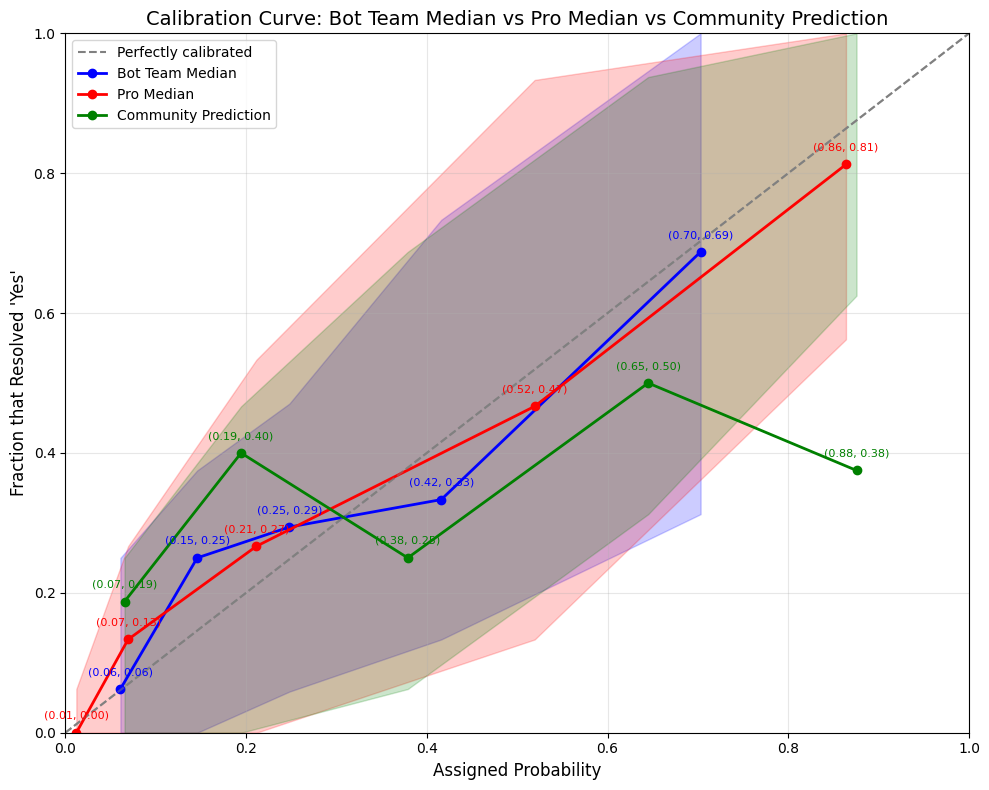

In [92]:
# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'pro_median', 'Pro Median', 'red')
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'forecast_values', 'Community Prediction', 'green')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title('Calibration Curve: Bot Team Median vs Pro Median vs Community Prediction', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()

REPEATING BOT v PRO ANALYSIS with BOT v CP

In [93]:
df_top_bot_pro_cp_forecasts.head(2)

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head,weighted_score,cp_post_id,forecast_values,cp_baseline_score
0,28922,"Will a senolytic therapy be approved for commercial sale by the US FDA before January 1, 2025?",0,2024-10-22 14:30:00,2024-10-22 14:30:00,28887,1.0,0.02,0.0040,-1.619469,-1.619469,1621.0,0.46,20.557666
1,28923,"Will a nuclear weapon be detonated as an act of war before January 1, 2025?\n",0,2024-10-22 14:30:00,2024-10-22 14:30:00,28888,1.0,0.02,0.0025,-1.769945,-1.769945,4779.0,0.80,57.835638


In [94]:
# Make df_cp_baseline_wide and df_pro_bot_cp_resolved_questions
df_cp_baseline_wide = df_top_bot_pro_cp_forecasts[['cp_post_id', 'bot_question_id', 'cp_baseline_score', 'forecast_values']]

In [95]:
df_cp_baseline_wide.head()

,cp_post_id,bot_question_id,cp_baseline_score,forecast_values
0,1621.0,28922,20.557666,0.46
1,4779.0,28923,57.835638,0.80
2,5587.0,28924,6.094273,0.35
4,28972.0,28959,12.848766,0.40
5,28974.0,28960,19.301116,0.45


In [96]:
# @title Create df_cp_bot_baseline_leaderboard, df_cp_bot_baseline_weighted_leaderboard

# df_pro_bot_baseline_weights already has all the weights
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.merge(df_cp_baseline_wide, on='bot_question_id', how='left')

# Remove rows where cp_post_id is NaN (only want overlapping questions here)
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.dropna(subset=['cp_post_id'])

# Create a list of columns to keep
forecaster_cols = ['cp_baseline_score', 'pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()
question_weighted_counts = df_filtered.notna().mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values,
    'Weighted Count': question_weighted_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count', 'Weighted Count']]

# Round to one decimal place
leaderboard['Baseline'] = leaderboard['Baseline'].round(1)
weighted_leaderboard['Weighted_Baseline'] = weighted_leaderboard['Weighted_Baseline'].round(1)
weighted_leaderboard['Weighted Count'] = weighted_leaderboard['Weighted Count'].round(1)

#leaderboard
weighted_leaderboard

,Rank,Forecaster,Weighted_Baseline,Count,Weighted Count
0,1,pro_median,2436.0,77,55.9
1,2,pgodzinai,1563.3,77,55.9
2,3,mf-bot-4,1499.3,77,55.9
3,4,estr.ai,1278.5,67,45.9
4,5,MWG,1268.5,67,48.9
5,6,bot_median,1248.8,77,55.9
6,7,histerio,1215.6,77,55.9
7,8,VeritasAI,1158.1,58,40.9
8,9,twsummerbot,1116.5,77,55.9
9,10,GreeneiBot2,1069.1,77,55.9


In [97]:
# @title Create df_cp_bot_forecasts, df_bot_vs_cp_peer

df_cp_forecasts = df_cp_baseline_wide[['cp_post_id', 'bot_question_id', 'forecast_values']]

want_cols = ['bot_question_id'] + [col for col in df_pro_bot_forecasts.columns if col in all_bots]

df_cp_bot_forecasts = df_cp_forecasts.merge(df_pro_bot_forecasts[want_cols], on='bot_question_id', how='left')

df_cp_bot_forecasts = df_cp_bot_forecasts.merge(df_top_bot_pro_forecasts[['bot_question_id', 'resolution', 'question_weight']], on='bot_question_id', how='left')

# Create a new DataFrame to store peer scores
df_bot_vs_cp_peer = df_cp_bot_forecasts.copy()
df_bot_vs_cp_peer = df_bot_vs_cp_peer[['resolution', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in all_bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_cp_bot_forecasts['resolution'] == 'yes',
        np.log(df_cp_bot_forecasts[bot] / df_cp_bot_forecasts['forecast_values']),
        np.log((1 - df_cp_bot_forecasts[bot]) / (1 - df_cp_bot_forecasts['forecast_values']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_cp_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team (TK: bot TEAM or median)
peer_score = np.where(
    df_cp_bot_forecasts['resolution'] == 'yes',
    np.log(df_cp_bot_forecasts['bot_median'] / df_cp_bot_forecasts['forecast_values']),
    np.log((1 - df_cp_bot_forecasts['bot_median']) / (1 - df_cp_bot_forecasts['forecast_values']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_cp_peer["bot_median"] = 100 * peer_score

In [98]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_cp_peer with question
weighting and the calculations for doing a weighted T test
"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# Cast weights as numeric
df_bot_vs_cp_peer['question_weight'] = pd.to_numeric(df_bot_vs_cp_peer['question_weight'], errors='coerce')

df_W_leaderboard = calculate_t_test(df_bot_vs_cp_peer, all_bots)

df_W_leaderboard

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
MWG,3042.2,48.9,62.2,94.983317,13.577638,4.578407,2.010702,89.5,34.9,0.999983,0.0033%
pgodzinai,2527.2,55.9,45.2,91.110812,12.181940,3.708716,2.004096,69.6,20.8,0.999757,0.0487%
bot_median,1996.6,55.9,35.7,103.002984,13.771979,2.591753,2.004096,63.3,8.1,0.993896,1.2208%
manticAI,1897.9,50.9,37.3,92.382040,12.943943,2.878503,2.008621,63.3,11.3,0.997066,0.5867%
GreeneiBot2,1787.1,55.9,31.9,95.896165,12.821764,2.491657,2.004096,57.6,6.3,0.992119,1.5763%
histerio,1583.3,55.9,28.3,93.985991,12.566365,2.252339,2.004096,53.5,3.1,0.985841,2.8317%
Cassie,1449.7,50.9,28.5,105.592061,14.794842,1.923644,2.008621,58.2,-1.3,0.969946,6.0109%
mf-bot-4,1428.0,55.9,25.5,105.926233,14.162831,1.802545,2.004096,53.9,-2.9,0.961527,7.6946%
mf-bot-5,1421.2,46.4,30.6,101.553199,14.906965,2.054231,2.013602,60.6,0.6,0.977132,4.5736%
twsummerbot,1418.6,55.9,25.4,106.904447,14.293622,1.774209,2.004096,54.0,-3.3,0.959215,8.1570%


In [99]:
# Write both leaderboards to csv
weighted_leaderboard.to_csv('weighted_baseline_bot_cp.csv', index=False)

df_W_leaderboard.to_csv('weighted_t_test_h2h_bot_vs_cp.csv', index=False)

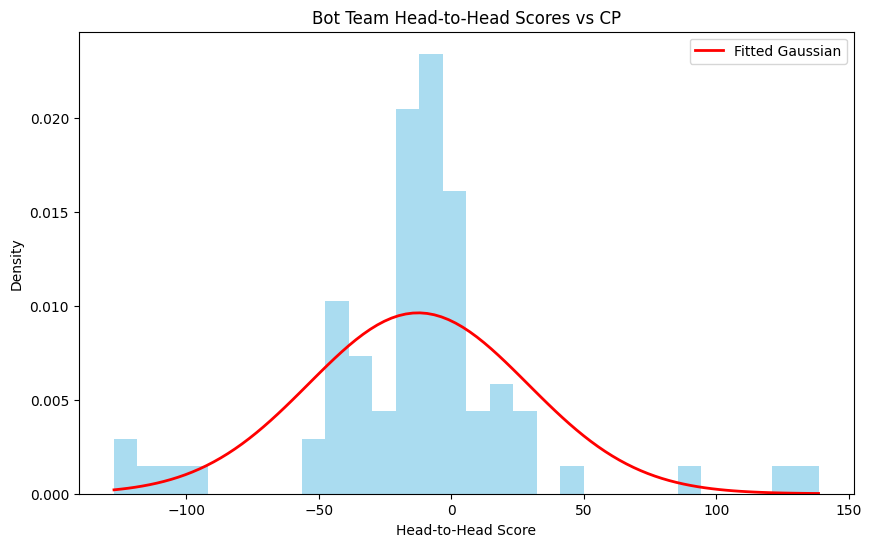

The average of 'head_to_head' is: -12.50


In [100]:
# Assuming df_top_bot_cp_forecasts is already defined and contains the 'head_to_head' column

# Extract the 'head_to_head' data
data = df_top_bot_pro_cp_forecasts['head_to_head']

# Calculate the mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data, bins=30, density=True, alpha=0.7, color='skyblue')

# Generate points for the fitted Gaussian curve
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mean, std)

# Plot the fitted Gaussian curve
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Gaussian')

# Customize the plot
plt.title('Bot Team Head-to-Head Scores vs CP')
plt.xlabel('Head-to-Head Score')
plt.ylabel('Density')
plt.legend()

# Add text annotation for the mean
#plt.text(0.95, 0.95, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

# Display the plot
plt.show()

# Print the average
print(f"The average of 'head_to_head' is: {mean:.2f}")